## Developing Multiple Runs Function

### Temperature Modeling Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numerical_modelling import *
from datetime import datetime
import pandas as pd

In [ ]:
def multiple_temperature_simulations(latitude=40.5853, longitude=-105.0844, logging = None,
                             T_max=45 + 273.15, T_initial=20 + 273.15, 
                             B_air=0.00367, v_air=15.89e-6, k_air=0.024, alpha_air=22.5e-6, h_max=200, N=4, 
							 box_parameters = [{
								'simulation_name': "basic_ABS",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.004, 0.004, 0.004, 0.004, 0.004, 0.004],
								'fan_flow': 0, 
								'heat_generation': 0, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': False,
								'shading_ranges': [],
								'k': 0.18, 
								'rho': 1070, 
								'Cp': 2000, 
								'emissivity': 0.66, 
								'absorptivity': 0.66, 
							 }],
                             start_date_time='2023-01-01 00:00:00', 
                             end_date_time='2023-12-31 23:00:00',
                             stop_event = None,
							):


	def run_and_output(data_2020, fan_speed_func, constant_q_flux,
					k, rho, Cp, emissivity, absorptivity, thicknesses, L, W, H, N, box_shading, shading_ranges):
		time_steps, _, avg_temp, battery_temp, dt, outside_temp = \
			run_model_reduced_complexity_and_memory(latitude, longitude, logging, 30, 7.5, start_date_time, data_2020, 
										fan_speed_func, air_velocity_func, avg_T, angle_func, constant_q_flux, h_external, 
										t_final, T_max, T_infinity_func, T_initial, 
										k, rho, Cp, G_func, emissivity, absorptivity, B_air, v_air, k_air, alpha_air, 
										thicknesses = thicknesses, L = L, W =W, H=H,N= N,h_max = h_max, stop_event = stop_event, 
										box_shading = box_shading, shading_ranges = shading_ranges)

		base_time = start_date_time
		model_df = pd.DataFrame({'seconds_past': time_steps})

		# Convert seconds_past to Timedelta and add to base_time
		model_df['datetime'] = model_df['seconds_past'].apply(lambda x: base_time + timedelta(seconds=x))
		model_df['internal'] = avg_temp
		model_df['outside_temp'] = outside_temp
		model_df.set_index('datetime', inplace=True)

		# save dataframes to pickles
		model_df_ten_min = model_df.resample('30min').mean()
		return model_df_ten_min

	start_date_time = datetime.strptime(start_date_time, '%Y-%m-%d %H:%M:%S')
	end_date_time = datetime.strptime(end_date_time, '%Y-%m-%d %H:%M:%S')

	timezone = get_timezone(latitude, longitude)
	df_mean = get_data(latitude=latitude, 
													longitude=longitude, 
													start_date_time = start_date_time,
													end_date_time = end_date_time,
													timezone = timezone,
													logging = logging,
													stop_event = stop_event
	)

	data_output = {}

	for box_parameter_set in box_parameters:
		simulation_name = box_parameter_set['simulation_name']
		L = box_parameter_set['L']
		W = box_parameter_set['W']
		H = box_parameter_set['H']
		thicknesses = box_parameter_set['thicknesses']
		fan_flow = box_parameter_set['fan_flow']
		heat_generation = box_parameter_set['heat_generation']
		fan_heat_generation = box_parameter_set['fan_heat_generation']
		fan_threshold = box_parameter_set['fan_threshold']
		box_shading = box_parameter_set['box_shading']
		shading_ranges = box_parameter_set['shading_ranges']
		k = box_parameter_set['k']
		rho = box_parameter_set['rho']
		Cp = box_parameter_set['Cp']
		emissivity = box_parameter_set['emissivity']
		absorptivity = box_parameter_set['absorptivity']

		logging.info(f"Modelling {simulation_name} with at ({round(latitude,4)}, {round(longitude, 4)})")

		### Calculated Params
		fan_flow_m3s = fan_flow * 0.0004719471999802417
		fan_speed = fan_flow_m3s / np.mean([L*W, L*H, W*H])
		t_final = (end_date_time - start_date_time).total_seconds()
		
		def constant_q_flux(T_internal): 
			if T_internal >= (fan_threshold + 273.15):
				return heat_generation + fan_heat_generation # from fan assembly
			else:
				return heat_generation

		def fan_speed_func(T_internal):
			if T_internal > (fan_threshold + 273.15):
				return fan_speed
			else:
				return 0

		try: 
			model_df_ten_min = run_and_output(df_mean, fan_speed_func = fan_speed_func, constant_q_flux = constant_q_flux,
									 k = k, rho = rho, Cp = Cp, emissivity = emissivity, absorptivity=absorptivity, thicknesses=thicknesses,
									 L = L, W= W, H= H, N = N, box_shading=box_shading, shading_ranges=shading_ranges)
			data_output[simulation_name] = box_parameter_set
			data_output[simulation_name]['data'] = model_df_ten_min
		except Exception as e:
			logging.error("Error running model" + str(e))
			data_output[simulation_name]['data'] = False

	return data_output

In [ ]:
import logging
from datetime import datetime as dt


# Initialize the logger
logging.basicConfig(
    filename='most_populous_cities.log',  # Name of the log file
    level=logging.INFO,                   # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S'           # Time format
)

# Create logger instance
logger = logging.getLogger()

results = multiple_temperature_simulations(latitude=40.5853, longitude=-105.0844, logging = logger,
                             T_max=45 + 273.15, T_initial=20 + 273.15, 
                             B_air=0.00367, v_air=15.89e-6, k_air=0.024, alpha_air=22.5e-6, h_max=200, N=4, 
							 box_parameters = [
								 {
								'simulation_name': "no_shading",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': False,
								'shading_ranges': [],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 },
								 {
								'simulation_name': "solar_shield",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': True,
								'shading_ranges': [],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 },
							 								 {
								'simulation_name': "full_shade",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': False,
								'shading_ranges': [('00:00:00', '23:59:59')],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 }
							 ],
                             start_date_time='2023-01-01 00:00:00', 
                             end_date_time='2023-01-05 23:00:00',
                             stop_event = None,
							)

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_6278/1511302742.py:49: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  model_df_ten_min = model_df.resample('10m').mean()
/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_6278/1511302742.py:49: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  model_df_ten_min = model_df.resample('10m').mean()


### Solar Optimization Function

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numerical_modelling import *
from datetime import datetime
import pandas as pd

In [ ]:
def multiple_solar_simulations(latitude=40.5853, longitude=-105.0844, logging = None,
                             start_solar_time='2023-01-01 00:00:00', 
                             end_solar_time='2023-12-31 23:00:00',
							 solar_parameters = [{
								'simulation_name':'',
								'solar_panel_area': 0.2, 
								'solar_panel_tilt': 0,
								'solar_panel_azimuth': 0,
								'solar_panel_efficiency': 0.18,
								'battery_rated_capacity': 120,
								'battery_efficiency': 0.8,
								'power_consumption': 5,
								'shading_ranges': [],
							 }],
                            dt_solar = 10,
                            stop_event = None,
                            ):
	print(f"*** Modelling Solar ({latitude}, {longitude}) ***")
	start_solar_time = datetime.strptime(start_solar_time, '%Y-%m-%d %H:%M:%S')
	end_solar_time = datetime.strptime(end_solar_time, '%Y-%m-%d %H:%M:%S')
	
	timezone = get_timezone(latitude, longitude)
	df_meterological = get_data(latitude=latitude, 
						longitude=longitude, 
						start_date_time = start_solar_time,
						end_date_time = end_solar_time,
						timezone = timezone,
						logging = logging,
						stop_event = stop_event
	)



	def run_and_output(solar_panel_area, solar_panel_tilt, solar_panel_azimuth, solar_panel_efficiency, battery_rated_capacity, battery_efficiency, shading_ranges, power_out_func):
		
		solar_time_steps, charges, power_ins, power_outs = solar_panel_model(latitude = latitude, longitude = longitude, logging = logging, 
							start_date_time = start_solar_time, end_date_time = end_solar_time, df =df_meterological,
							solar_panel_area = solar_panel_area, solar_panel_tilt = solar_panel_tilt, solar_panel_azimuth = solar_panel_azimuth, 
							solar_panel_efficiency = solar_panel_efficiency, 
							battery_rated_capacity = battery_rated_capacity, battery_efficiency = battery_efficiency, dt = dt_solar,
							power_out_func = power_out_func, stop_event = stop_event, shading_ranges = shading_ranges)

		solar_df = pd.DataFrame({'seconds_past': solar_time_steps})
		solar_df['datetime'] = solar_df['seconds_past'].apply(lambda x: start_solar_time + timedelta(seconds=x))
		solar_df['charges'] = charges
		#solar_df['power_ins'] = power_ins
		#solar_df['power_outs'] = power_outs
		solar_df.set_index('datetime', inplace=True)
		solar_df = solar_df.resample('30min').mean()
		return solar_df
	
	data_output = {}

	for solar_parameter_set in solar_parameters:
		simulation_name = solar_parameter_set['simulation_name']
		solar_panel_area = solar_parameter_set['solar_panel_area']
		solar_panel_tilt = solar_parameter_set['solar_panel_tilt']
		solar_panel_azimuth = solar_parameter_set['solar_panel_azimuth']
		solar_panel_efficiency = solar_parameter_set['solar_panel_efficiency']
		battery_rated_capacity = solar_parameter_set['battery_rated_capacity']
		battery_efficiency = solar_parameter_set['battery_efficiency']
		power_consumption = solar_parameter_set['power_consumption']
		shading_ranges = solar_parameter_set['shading_ranges']
		
		def power_out_func(*args, **kwargs):
			return power_consumption
		
		logging.info(f"Modelling at ({round(latitude,4)}, {round(longitude, 4)})")

		try: 
			solar_df = run_and_output(solar_panel_area = solar_panel_area, 
									 solar_panel_tilt = solar_panel_tilt, 
									 solar_panel_azimuth = solar_panel_azimuth, 
									 solar_panel_efficiency = solar_panel_efficiency, 
									 battery_rated_capacity = battery_rated_capacity, 
									 battery_efficiency = battery_efficiency, 
									 shading_ranges = shading_ranges, 
									 power_out_func = power_out_func)
			data_output[simulation_name] = solar_parameter_set
			data_output[simulation_name]['data'] = solar_df
		except Exception as e:
			logging.error("Error running model" + str(e))
			data_output[simulation_name]['data'] = False

	return data_output
	

## Generate lat, lon pairs for world

In [73]:
def generate_grid_points(latitude_step = 2, 
						 longitude_step = 2, 
						 latitude_bounds = [-180, 180], 
						 longitude_bounds = [-180, 180]):

	import numpy as np
	import geopandas as gpd
	from shapely.geometry import Point

	# Load Natural Earth dataset for land boundaries
	shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
	world = gpd.read_file(shapefile_path)
	#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
	africa = world.loc[(world['CONTINENT'] != 'Seven seas (open ocean)') & (world['CONTINENT'] != 'Antarctica')]

	# Define grid resolution
	latitude_step = 2
	longitude_step = 2

	# Define bounds for Africa
	min_latitude, max_latitude = latitude_bounds
	min_longitude, max_longitude = longitude_bounds

	# Generate grid
	latitudes = np.arange(min_latitude, max_latitude + latitude_step, latitude_step)
	longitudes = np.arange(min_longitude, max_longitude + longitude_step, longitude_step)

	# Create grid points
	grid_points = [Point(lon, lat) for lat in latitudes for lon in longitudes]

	# Filter for points within Africa land boundaries
	grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs='EPSG:4326')
	land_points = grid_gdf[grid_gdf.within(africa.unary_union)]


	from shapely.geometry import Point
	import matplotlib.pyplot as plt

	# Plot the map
	fig, ax = plt.subplots(figsize=(12, 12))
	africa.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
	land_points.plot(ax=ax, color='blue', markersize=1, label='Grid Points')

	# Customize plot
	plt.title('Grid Points Over Land Only', fontsize=16)
	plt.xlabel('Longitude', fontsize=12)
	plt.ylabel('Latitude', fontsize=12)
	plt.grid(True, linestyle='--', alpha=0.5)
	plt.legend(loc='lower left')
	plt.show()

	return land_points


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83873/1471888747.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  land_points = grid_gdf[grid_gdf.within(africa.unary_union)]


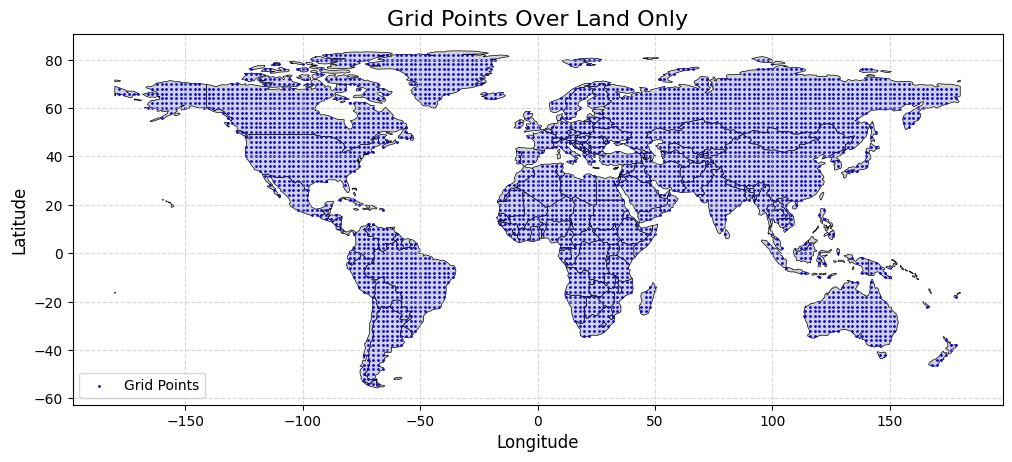

In [74]:
land_points = generate_grid_points()

In [89]:
list(land_points['geometry'])[2462:2464]

[<POINT (-94 52)>, <POINT (-92 52)>]

In [80]:
list(land_points)

['geometry']

In [ ]:
import logging
from datetime import datetime as dt

from datetime import datetime
import os

time = datetime.strftime(datetime.now(), "%m_%d_%H_%M")
dir_name = f'global_modeling_2_degrees_{time}'
os.mkdir(dir_name)


# Initialize the logger
logging.basicConfig(
    filename='global_temp_model.log',  # Name of the log file
    level=logging.INFO,                   # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S'           # Time format
)

# Create logger instance
logger = logging.getLogger()


for i in land_points.geometry[0:1]:
	lon = int(str(i).split(' ')[1][1:])
	lat = int(str(i).split(' ')[2][:-1])
	
	results = multiple_temperature_simulations(latitude=lat, longitude=lon, logging = logger,
                             T_max=45 + 273.15, T_initial=20 + 273.15, 
                             B_air=0.00367, v_air=15.89e-6, k_air=0.024, alpha_air=22.5e-6, h_max=200, N=4, 
							 box_parameters = [
								 {
								'simulation_name': "no_shading",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': False,
								'shading_ranges': [],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 },
								{
								'simulation_name': "solar_shield",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': True,
								'shading_ranges': [],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 },
							 								 {
								'simulation_name': "full_shade",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': False,
								'shading_ranges': [('00:00:00', '23:59:59')],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 }
							 ],
                             start_date_time='2023-01-01 00:00:00', 
                             end_date_time='2023-01-05 23:00:00',
                             stop_event = None,
							)
	sub_dir = f'{dir_name}/{lat}_{lon}'
	os.mkdir(sub_dir)
	results['no_shading']['data'].to_pickle(sub_dir + '/no_shading')
	results['solar_shield']['data'].to_pickle(sub_dir + '/solar_shield')
	results['full_shade']['data'].to_pickle(sub_dir + '/full_shade')



In [42]:
results['no_shading']['data']

,seconds_past,internal,battery_temp,outside_temp
datetime,,,,
2023-01-01 00:00:00,897.772152,288.460968,288.460968,278.531830
2023-01-01 00:30:00,2699.341772,283.690582,283.690582,278.556824
2023-01-01 01:00:00,4500.911392,281.980774,281.980774,278.572418
2023-01-01 01:30:00,6299.468354,281.356842,281.356842,278.577362
2023-01-01 02:00:00,8098.025316,281.139221,281.139221,278.572876
...,...,...,...,...
2023-01-05 21:00:00,422100.531646,282.835266,282.835266,280.164154
2023-01-05 21:30:00,423899.088608,282.529205,282.529205,279.919525
2023-01-05 22:00:00,425700.658228,282.269348,282.269348,279.690826


In [ ]:
import 

## Do solar modeling for all of Africa

In [90]:
import logging
from datetime import datetime as dt

from datetime import datetime
import os

time = datetime.strftime(datetime.now(), "%m_%d_%H_%M")
dir_name = f'global_solar_modeling_2_degrees_{time}'
os.mkdir(dir_name)


# Initialize the logger
logging.basicConfig(
    filename='global_temp_model.log',  # Name of the log file
    level=logging.INFO,                   # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S'           # Time format
)

# Create logger instance
logger = logging.getLogger()

In [113]:
for i in land_points.geometry[0:1]:
	lon = int(str(i).split(' ')[1][1:])
	lat = int(str(i).split(' ')[2][:-1])
	lat = -20
	lon = -69.3
	
	results = multiple_solar_simulations(latitude=lat, longitude=lon, logging = logger,
							 solar_parameters = [{
								'simulation_name':'base',
								'solar_panel_area': 0.5, 
								'solar_panel_tilt': 0,
								'solar_panel_azimuth': 0,
								'solar_panel_efficiency': 0.18,
								'battery_rated_capacity': 300,
								'battery_efficiency': 0.8,
								'power_consumption': 5,
								'shading_ranges': [],
							 }],
                             start_solar_time='2023-01-01 00:00:00', 
                             end_solar_time='2023-12-31 23:00:00',
						     dt_solar = 10,
                             stop_event = None,
							)
	
	sub_dir = f'{dir_name}/{lat}_{lon}'
	os.mkdir(sub_dir)
	results['base']['data'].to_pickle(sub_dir + '/base')

*** Modelling Solar (-20, -69.3) ***


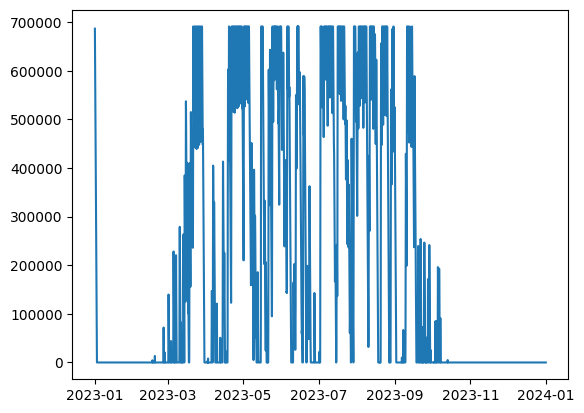

In [107]:
plt.plot(results['base']['data'].index, results['base']['data']['charges'])

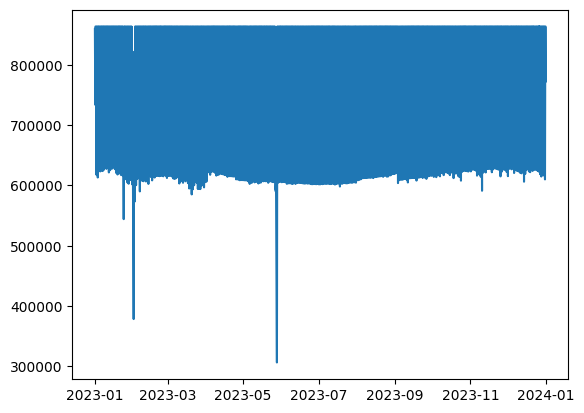

In [114]:
plt.plot(results['base']['data'].index, results['base']['data']['charges'])

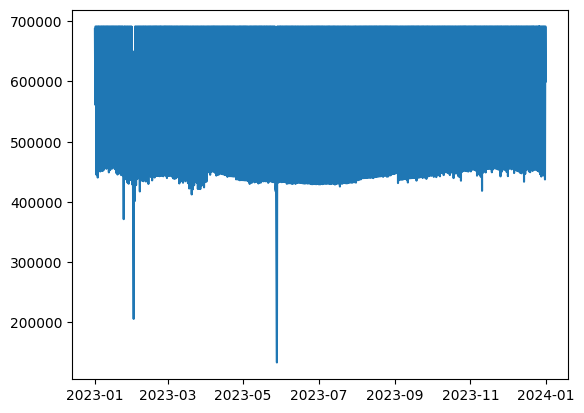

In [ ]:
plt.plot(results['base']['data'].index, results['base']['data']['charges'])

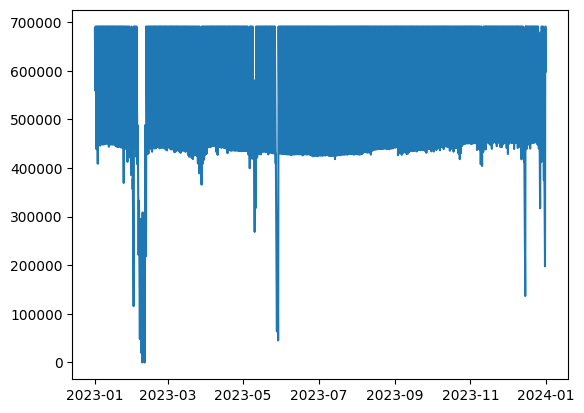

In [102]:
plt.plot(results['base']['data'].index, results['base']['data']['charges'])

In [121]:
dat = pd.read_pickle("global_solar_modeling_2_degrees_01_06_20_40/-54_-72.csv")
dat2 = pd.read_pickle("global_solar_modeling_2_degrees_01_06_20_40/-54_-70.csv")

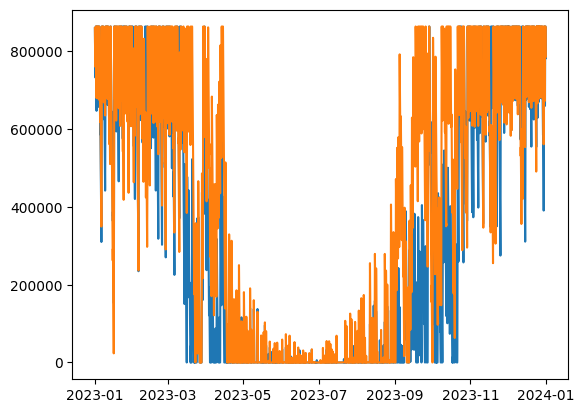

In [122]:
plt.plot(dat.index, dat['charges'])
plt.plot(dat2.index, dat2['charges'])

## Analyzing Temp Data

In [197]:
import os

# Specify the directory
directory = "global_modeling_2_degrees_all"

# List all files in the directory and its subdirectories
coords = []
for root, dirs, files in os.walk(directory):
    for file in files:
        coord = root.split("/")[1]
        if coord not in coords:
            coords.append(coord)


In [567]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import pandas as pd
from scipy.ndimage import generic_filter

# Define a function to average over valid (non-NaN) neighbors
def average_neighbors(values):
    valid_values = values[~np.isnan(values)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan  # If no valid neighbors, return NaN

def fraction_days(coords, sensitivity, threshold = 273.15 + 45, lower_threshold = 273.15 - 20):
    # Initialize a dictionary to store results
    fractions = []

    # Process each coordinate
    for coord in coords:  # Limit to the first 10 coordinates
        lat = int(coord.split('_')[0])
        lon = int(coord.split('_')[1])

        # Load the DataFrame
        try:
            df = pd.read_pickle(f'global_modeling_2_degrees_all/{coord}/{sensitivity}.pkl')

            # Ensure datetime index is in place
            if not isinstance(df.index, pd.DatetimeIndex):
                df.set_index('datetime', inplace=True)

            # Resample data to daily frequency and check for threshold
            days_with_threshold = (df['internal'].resample('D').max() > threshold) | (df['internal'].resample('D').min() < lower_threshold)

            # Calculate fraction of days exceeding the threshold
            fraction_above_threshold = days_with_threshold.sum() / len(days_with_threshold)
            fractions.append({'lat': lat, 'lon': lon, 'fraction': fraction_above_threshold})

        except Exception as e:
            print(f"Error processing {coord}: {e}")

    # Convert results to a DataFrame
    fraction_df = pd.DataFrame(fractions)

    # Create pivot table for heatmap
    heatmap_data = fraction_df.pivot(index='lat', columns='lon', values='fraction')

    # Apply the filter: 3x3 window to average valid neighbors
    # Apply only on NaN positions (using 'constant' mode for filling boundary)
    filled_values = generic_filter(heatmap_data.values, average_neighbors, size=2, mode='constant', cval=np.nan)

    # Convert the result into a DataFrame while keeping the original index and columns
    new = pd.DataFrame(filled_values, index=heatmap_data.index, columns=heatmap_data.columns)

    # Now, only update NaN values in the original dataframe with the filled ones
    result = heatmap_data.copy()  # Make a copy to preserve the original
    result[heatmap_data.isna()] = new[heatmap_data.isna()]

    return result

def fraction_points(coords, sensitivity, threshold = 273.15 + 45, lower_threshold = 273.15 - 20):
    # Initialize a dictionary to store results
    fractions = []

    # Process each coordinate
    for coord in coords:  # Limit to the first 10 coordinates
        lat = int(coord.split('_')[0])
        lon = int(coord.split('_')[1])

        # Load the DataFrame
        try:
            df = pd.read_pickle(f'global_modeling_2_degrees_all/{coord}/{sensitivity}.pkl')

            # Ensure datetime index is in place
            if not isinstance(df.index, pd.DatetimeIndex):
                df.set_index('datetime', inplace=True)

            # Resample data to daily frequency and check for threshold
            days_with_threshold  = (df['internal'] > threshold) | (df['internal'] < lower_threshold)

            # Calculate fraction of days exceeding the threshold
            fraction_above_threshold = days_with_threshold.sum() / len(days_with_threshold)
            fractions.append({'lat': lat, 'lon': lon, 'fraction': fraction_above_threshold})

        except Exception as e:
            print(f"Error processing {coord}: {e}")

    # Convert results to a DataFrame
    fraction_df = pd.DataFrame(fractions)

    # Create pivot table for heatmap
    heatmap_data = fraction_df.pivot(index='lat', columns='lon', values='fraction')
    
    # Apply the filter: 3x3 window to average valid neighbors
    # Apply only on NaN positions (using 'constant' mode for filling boundary)
    filled_values = generic_filter(heatmap_data.values, average_neighbors, size=2, mode='constant', cval=np.nan)

    # Convert the result into a DataFrame while keeping the original index and columns
    new = pd.DataFrame(filled_values, index=heatmap_data.index, columns=heatmap_data.columns)

    # Now, only update NaN values in the original dataframe with the filled ones
    result = heatmap_data.copy()  # Make a copy to preserve the original
    result[heatmap_data.isna()] = new[heatmap_data.isna()]

    return result

#heatmap_data = fraction_days(coords, sensitivity = 'no_shading', threshold = 273.15 + 45, lower_threshold = 273.15 - 50)
#heatmap_points = fraction_points(coords,  sensitivity = 'no_shading', threshold = 273.15 + 45, lower_threshold = 273.15 - 50)

In [655]:
days_45_no_shading = fraction_days(coords, sensitivity = 'no_shading', threshold = 273.15 + 45, lower_threshold = 273.15 - 500)
time_45_no_shading = fraction_points(coords, sensitivity = 'no_shading', threshold = 273.15 + 45, lower_threshold = 273.15 - 500)
days_45_solar_shading = fraction_days(coords, sensitivity = 'solar_shield', threshold = 273.15 + 45, lower_threshold = 273.15 - 500)
time_45_solar_shading = fraction_points(coords, sensitivity = 'solar_shield', threshold = 273.15 + 45, lower_threshold = 273.15 - 500)
days_45_full_shading = fraction_days(coords, sensitivity = 'full_shade', threshold = 273.15 + 45, lower_threshold = 273.15 - 500)
time_45_full_shading = fraction_points(coords, sensitivity = 'full_shade', threshold = 273.15 + 45, lower_threshold = 273.15 - 500)


Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/no_shading.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/no_shading.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/solar_shield.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/solar_shield.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/full_shade.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/full_shade.pkl'


In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import generic_filter

# Define a function to average over valid (non-NaN) neighbors
def average_neighbors(values):
    valid_values = values[~np.isnan(values)]
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return np.nan  # If no valid neighbors, return NaN

# Apply the filter: 3x3 window to average valid neighbors
# Apply only on NaN positions (using 'constant' mode for filling boundary)
filled_values = generic_filter(days_45_no_shading.values, average_neighbors, size=2, mode='constant', cval=np.nan)

# Convert the result into a DataFrame while keeping the original index and columns
new = pd.DataFrame(filled_values, index=days_45_no_shading.index, columns=days_45_no_shading.columns)

# Now, only update NaN values in the original dataframe with the filled ones
result = days_45_no_shading.copy()  # Make a copy to preserve the original
result[days_45_no_shading.isna()] = new[days_45_no_shading.isna()]


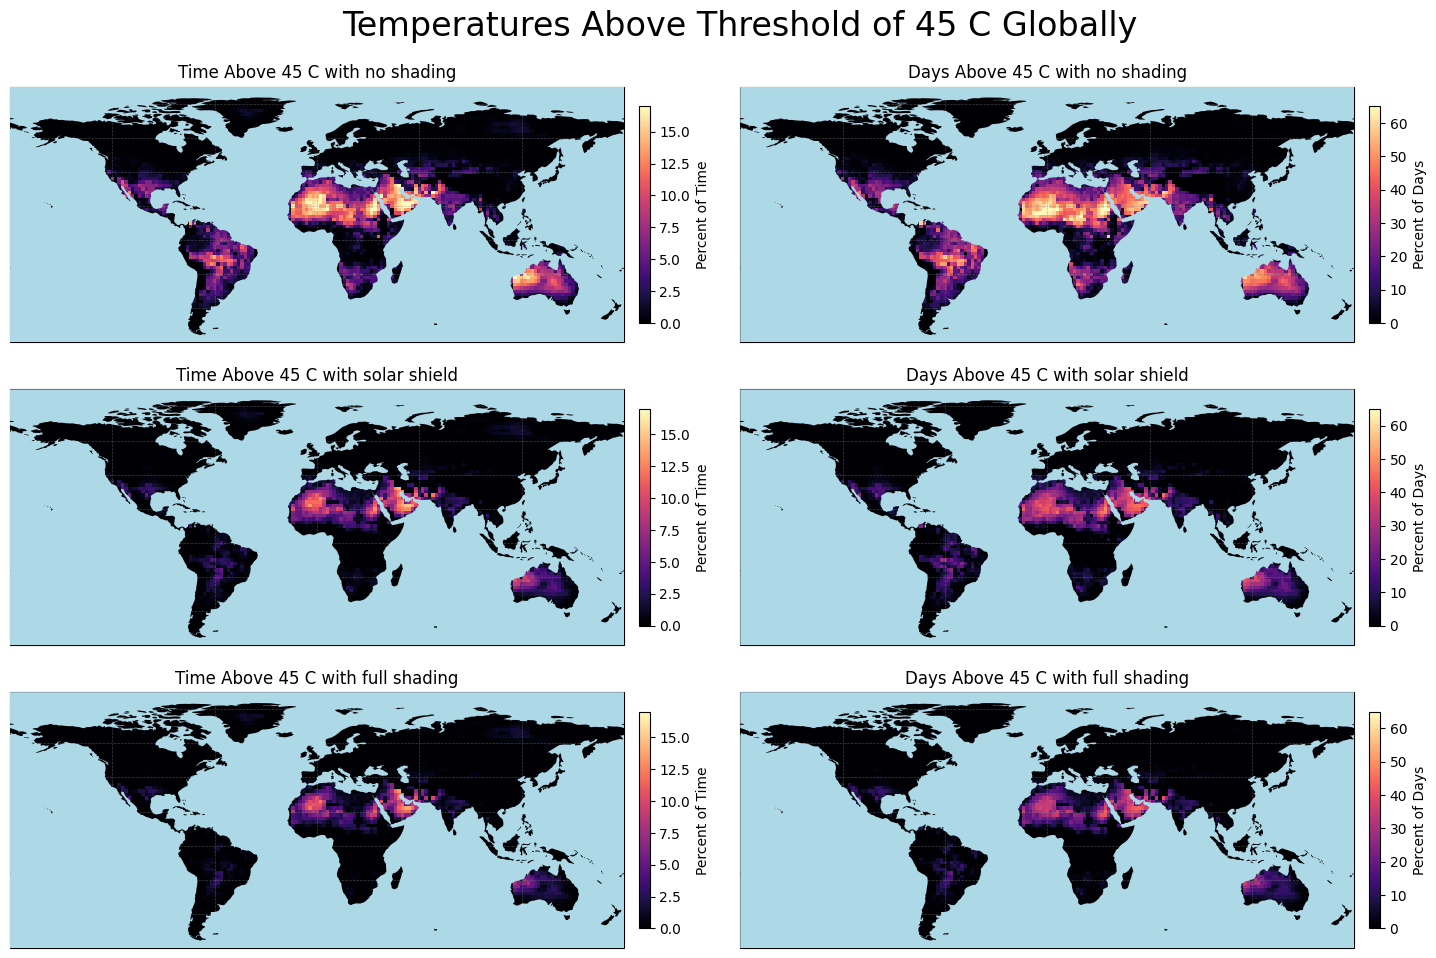

In [ ]:
from matplotlib import colors

def plot_single_heatmap(ax, data, vmin, vmax, days = False, sensitivity = "no_shading",threshold = 45, extent=[-180, 180, -60, 90]):
    """
    Plots a single heatmap on the provided axis.

    Parameters:
        ax (GeoAxes): A Cartopy GeoAxes object for the subplot.
        data (np.ndarray): 2D array containing the heatmap data.
        extent (list): Map extent in the format [lon_min, lon_max, lat_min, lat_max].
        title (str): Title for the subplot (default is None).

    Returns:
        None
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, facecolor=plt.cm.magma(0))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', alpha=0.5)

    # Plot the heatmap
    lons, lats = np.meshgrid(days_45_no_shading.columns, days_45_no_shading.index)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    im = ax.pcolormesh(
        lons, lats, data *100,
        cmap='magma', norm = norm, shading='auto', transform=ccrs.PlateCarree(), zorder=2
    )
    ax.add_feature(cfeature.OCEAN, zorder = 3, facecolor='lightblue')


    # Add colorbar
    cbar = plt.colorbar(im, orientation='vertical', ax=ax, shrink=0.7, pad=0.02)
    
    if days:
        cbar.set_label('Percent of Days')
        ax.set_title(f"Days Above {threshold} C with {sensitivity}")

    else:
        cbar.set_label('Percent of Time')
        ax.set_title(f"Time Above {threshold} C with {sensitivity}")


    # Add gridlines and labels
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Temperatures Above Threshold of 45 C Globally ", fontsize=24, x=0.5)

plot_single_heatmap(axes[0][1], vmin = 0, vmax = 65, data = days_45_no_shading, days = True, sensitivity = "no shading", threshold = 45)
plot_single_heatmap(axes[1][1], vmin = 0, vmax = 65, data = days_45_solar_shading, days = True, sensitivity = "solar shield", threshold = 45)
plot_single_heatmap(axes[2][1], vmin = 0, vmax = 65, data = days_45_full_shading, days = True, sensitivity = "full shading", threshold = 45)
plot_single_heatmap(axes[0][0], vmin = 0, vmax = 17, data = time_45_no_shading, days = False, sensitivity = "no shading", threshold = 45)
plot_single_heatmap(axes[1][0], vmin = 0, vmax = 17, data = time_45_solar_shading, days = False, sensitivity = "solar shield", threshold = 45)
plot_single_heatmap(axes[2][0], vmin = 0, vmax = 17, data = time_45_full_shading, days = False, sensitivity = "full shading", threshold = 45)

# Adjust layouta
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(top=0.93)  # Reduce the top margin

plt.show()

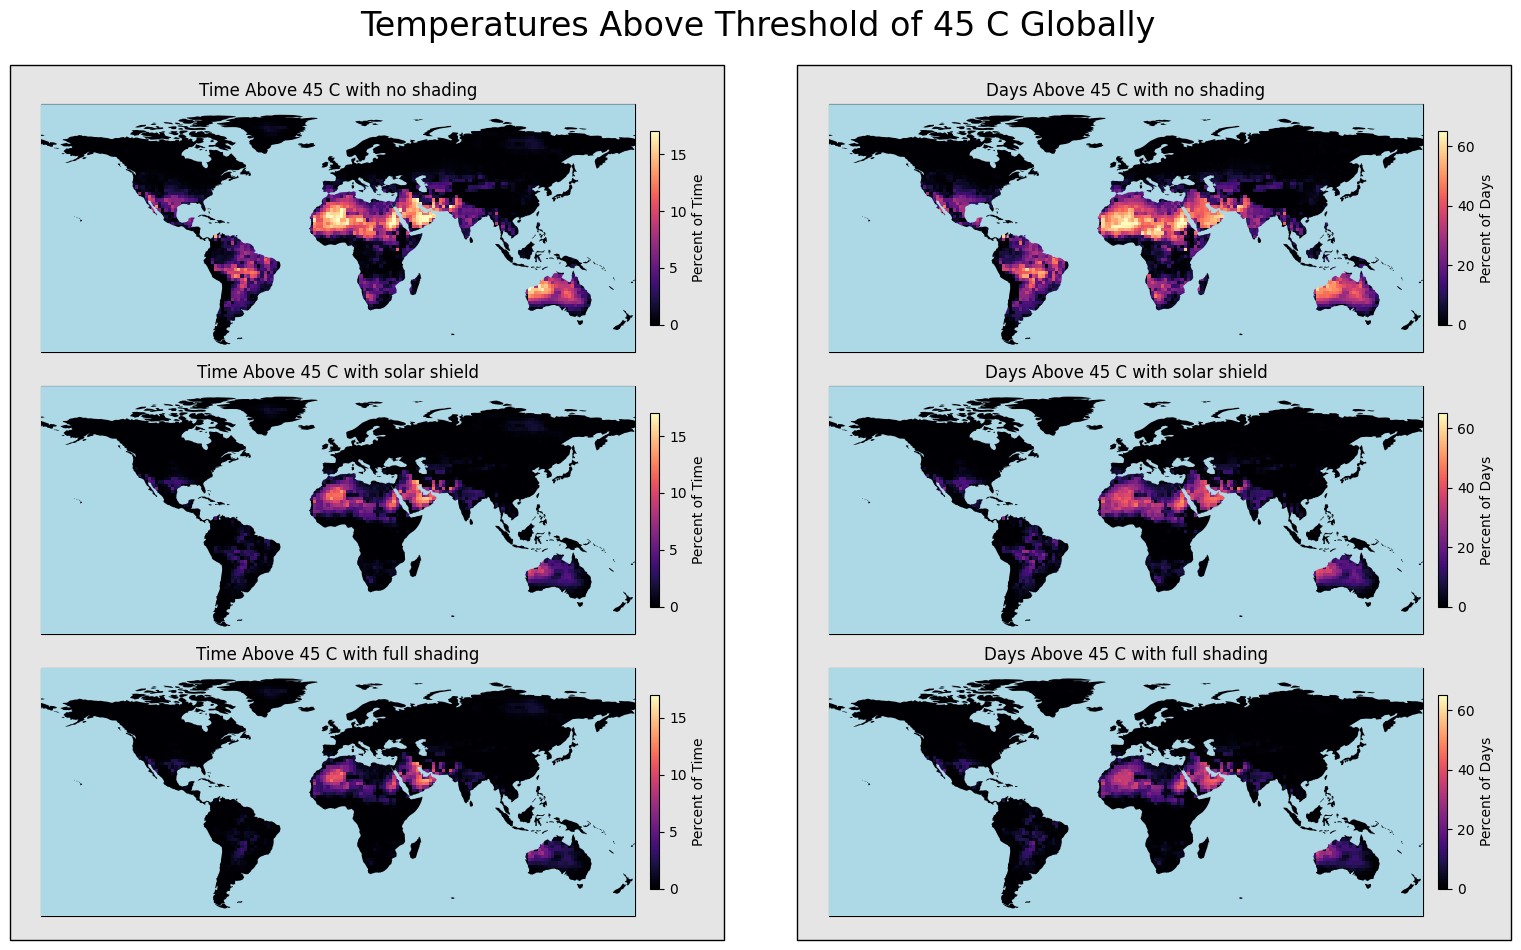

In [464]:
from matplotlib import colors

def plot_single_heatmap(ax, data, vmin, vmax, days = False, sensitivity = "no_shading",threshold = 45, extent=[-180, 180, -60, 90]):
    """
    Plots a single heatmap on the provided axis.

    Parameters:
        ax (GeoAxes): A Cartopy GeoAxes object for the subplot.
        data (np.ndarray): 2D array containing the heatmap data.
        extent (list): Map extent in the format [lon_min, lon_max, lat_min, lat_max].
        title (str): Title for the subplot (default is None).

    Returns:
        None
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, facecolor=plt.cm.magma(0))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', alpha=0.5)

    # Plot the heatmap
    lons, lats = np.meshgrid(days_45_no_shading.columns, days_45_no_shading.index)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    im = ax.pcolormesh(
        lons, lats, data *100,
        cmap='magma', norm = norm, shading='auto', transform=ccrs.PlateCarree(), zorder=2
    )
    ax.add_feature(cfeature.OCEAN, zorder = 3, facecolor='lightblue')


    # Add colorbar
    cbar = plt.colorbar(im, orientation='vertical', ax=ax, shrink=0.7, pad=0.02)
    
    if days:
        cbar.set_label('Percent of Days')
        ax.set_title(f"Days Above {threshold} C with {sensitivity}")

    else:
        cbar.set_label('Percent of Time')
        ax.set_title(f"Time Above {threshold} C with {sensitivity}")


    # Add gridlines and labels
    #ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Temperatures Above Threshold of 45 C Globally ", fontsize=24, x=0.5)


# Dimensions for tight-fitting grey boxes
left_box = patches.Rectangle(
    (0.057, 0.05), 0.42, 0.875,  # (x, y), width, height
    linewidth=1.0, edgecolor='black', facecolor='#E5E5E5', zorder=-1
)
right_box = patches.Rectangle(
    (0.52, 0.05), 0.42, 0.875,  # (x, y), width, height
    linewidth=1.0, edgecolor='black', facecolor='#E5E5E5', zorder=-1
)

# Add the boxes to the figure
fig.add_artist(left_box)
fig.add_artist(right_box)


plot_single_heatmap(axes[0][1], vmin = 0, vmax = 65, data = days_45_no_shading, days = True, sensitivity = "no shading", threshold = 45)
plot_single_heatmap(axes[1][1], vmin = 0, vmax = 65, data = days_45_solar_shading, days = True, sensitivity = "solar shield", threshold = 45)
plot_single_heatmap(axes[2][1], vmin = 0, vmax = 65, data = days_45_full_shading, days = True, sensitivity = "full shading", threshold = 45)
plot_single_heatmap(axes[0][0], vmin = 0, vmax = 17, data = time_45_no_shading, days = False, sensitivity = "no shading", threshold = 45)
plot_single_heatmap(axes[1][0], vmin = 0, vmax = 17, data = time_45_solar_shading, days = False, sensitivity = "solar shield", threshold = 45)
plot_single_heatmap(axes[2][0], vmin = 0, vmax = 17, data = time_45_full_shading, days = False, sensitivity = "full shading", threshold = 45)

# Adjust layouta
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(left=0.075, right=0.96, top = 0.9, bottom = 0.06, wspace=0.1, hspace=0.02)

#plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.05, wspace=0.2, hspace=0)

plt.show()

/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83873/714193409.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


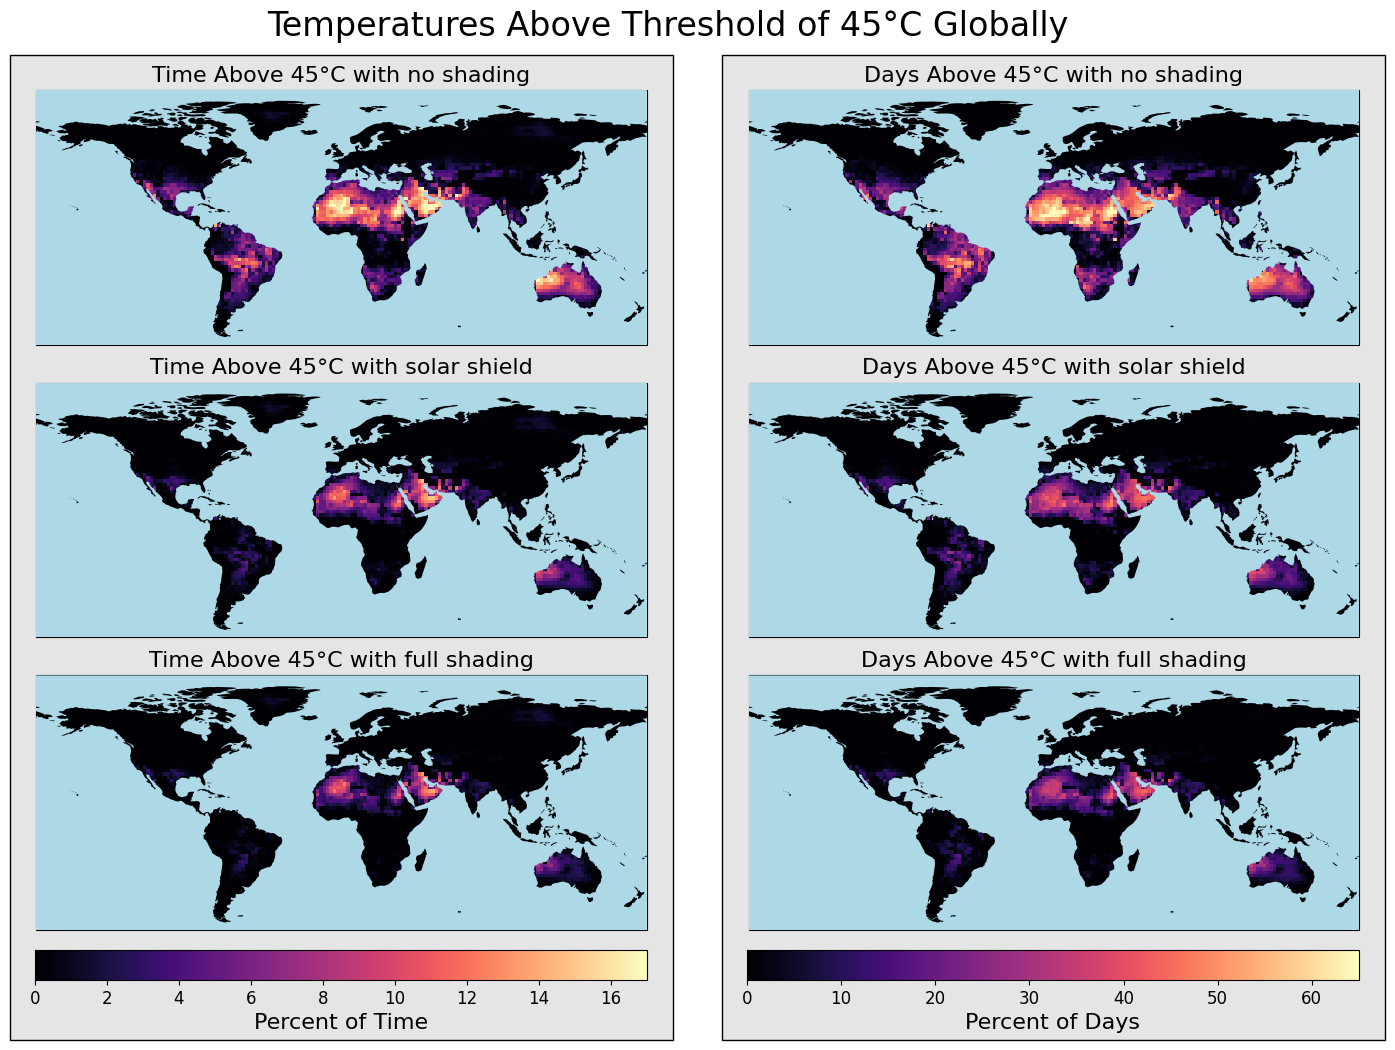

In [530]:
from matplotlib import colors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_single_heatmap(ax, data, vmin, vmax, days=False, sensitivity="no_shading", threshold=45, extent=[-180, 180, -60, 90]):
    """
    Plots a single heatmap on the provided axis.

    Parameters:
        ax (GeoAxes): A Cartopy GeoAxes object for the subplot.
        data (np.ndarray): 2D array containing the heatmap data.
        vmin, vmax (float): Color scale limits.
        days (bool): Whether to label as "days" or "time".
        sensitivity (str): Shading type.
        threshold (int): Temperature threshold.
        extent (list): Map extent [lon_min, lon_max, lat_min, lat_max].

    Returns:
        im (mappable): The plotted heatmap.
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.OCEAN, zorder=3, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, facecolor=plt.cm.magma(0))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', alpha=0.5)

    # Generate heatmap
    lons, lats = np.meshgrid(data.columns, data.index)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    ax.pcolormesh(
        lons, lats, data * 100,
        cmap='magma', norm=norm, shading='auto', transform=ccrs.PlateCarree(), zorder=2
    )
    
    ax.set_title(f"{'Days' if days else 'Time'} Above {threshold}°C with {sensitivity}", fontsize = 16)

# Create figure with subplots
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Temperatures Above Threshold of 45°C Globally", fontsize=24, x=0.5)

# Add grey background boxes
left_box = patches.Rectangle((0.113, -0.05), 0.39, 0.985, linewidth=1.0, edgecolor='black', facecolor='#E5E5E5', zorder=-1)
right_box = patches.Rectangle((0.532, -0.05), 0.39, 0.985, linewidth=1.0, edgecolor='black', facecolor='#E5E5E5', zorder=-1)
fig.add_artist(left_box)
fig.add_artist(right_box)

plot_single_heatmap(axes[0, 1], days_45_no_shading, vmin=0, vmax=65, days=True, sensitivity="no shading")
plot_single_heatmap(axes[1, 1], days_45_solar_shading, vmin=0, vmax=65, days=True, sensitivity="solar shield")
plot_single_heatmap(axes[2, 1], days_45_full_shading, vmin=0, vmax=65, days=True, sensitivity="full shading")
plot_single_heatmap(axes[0, 0], time_45_no_shading, vmin=0, vmax=17, days=False, sensitivity="no shading")
plot_single_heatmap(axes[1, 0], time_45_solar_shading, vmin=0, vmax=17, days=False, sensitivity="solar shield")
plot_single_heatmap(axes[2, 0], time_45_full_shading, vmin=0, vmax=17, days=False, sensitivity="full shading")

# Create shared colorbars below each column
norm_days = colors.Normalize(vmin=0, vmax=65)
norm_time = colors.Normalize(vmin=0, vmax=17)

# Get positions of the bottom row of subplots for precise colorbar placement
pos_left = axes[2][0].get_position()
pos_right = axes[2][1].get_position()

# Create shared colorbars using the correct colormap and normalizatio
cbar_ax_left = fig.add_axes([0.1275, 0.01, 0.36, 0.03])  # [x, y, width, height]
cbar_ax_right = fig.add_axes([0.1275 + 0.419, 0.01, 0.36, 0.03])  # [x, y, width, height]

cbar_left = fig.colorbar(
    plt.cm.ScalarMappable(cmap='magma', norm=norm_time),
    cax=cbar_ax_left, orientation='horizontal'
)
cbar_right = fig.colorbar(
    plt.cm.ScalarMappable(cmap='magma', norm=norm_days),
    cax=cbar_ax_right, orientation='horizontal'
)

# Set colorbar labels
cbar_left.set_label('Percent of Time', fontsize=16)
cbar_right.set_label('Percent of Days', fontsize=16)

# Adjust tick font sizes
cbar_left.ax.tick_params(labelsize=12)
cbar_right.ax.tick_params(labelsize=12)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(left=0.075, right=0.96, top=0.9, bottom=0.06, wspace=-0.1, hspace=0.15)

plt.show()


In [589]:
print(round((time_45_full_shading.mean()).mean() * 100, 3))
print(round((time_45_solar_shading.mean()).mean() * 100, 3))
print(round((time_45_no_shading.mean()).mean() * 100, 3))

0.447
0.647
1.638


In [588]:
print(round((days_45_full_shading.mean()).mean() * 100, 3))
print(round((days_45_solar_shading.mean()).mean() * 100, 3))
print(round((days_45_no_shading.mean()).mean() * 100, 3))

2.029
2.956
7.305


In [568]:
cold_days_45_no_shading = fraction_days(coords, sensitivity = 'no_shading', threshold = 273.15 + 1000, lower_threshold = 273.15 - 0)
cold_time_45_no_shading = fraction_points(coords, sensitivity = 'no_shading', threshold = 273.15 + 1000, lower_threshold = 273.15 - 0)
cold_days_45_solar_shading = fraction_days(coords, sensitivity = 'solar_shield', threshold = 273.15 + 1000, lower_threshold = 273.15 - 0)
cold_time_45_solar_shading = fraction_points(coords, sensitivity = 'solar_shield', threshold = 273.15 + 1000, lower_threshold = 273.15 - 0)
cold_days_45_full_shading = fraction_days(coords, sensitivity = 'full_shade', threshold = 273.15 + 1000, lower_threshold = 273.15 - 0)
cold_time_45_full_shading = fraction_points(coords, sensitivity = 'full_shade', threshold = 273.15 + 1000, lower_threshold = 273.15 - 0)

Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/no_shading.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/no_shading.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/solar_shield.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/solar_shield.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/full_shade.pkl'
Error processing 52_-94: [Errno 2] No such file or directory: 'global_modeling_2_degrees_all/52_-94/full_shade.pkl'


/var/folders/y_/wsfrr6n944q4gw07ywp8l2_00000gn/T/ipykernel_83873/492894675.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


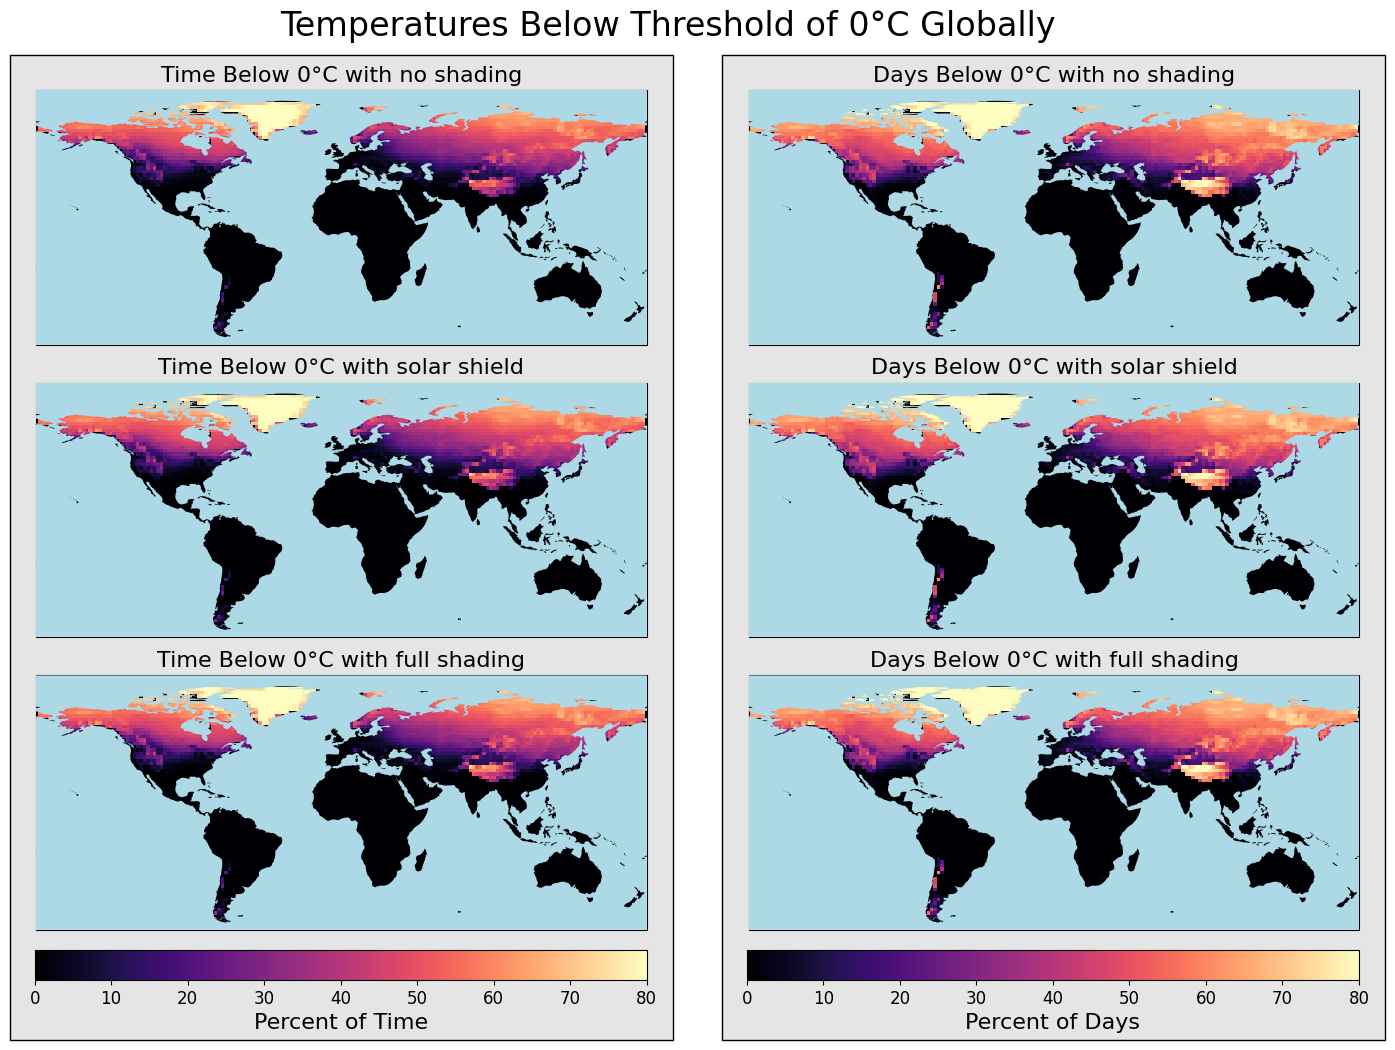

In [585]:
from matplotlib import colors
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_single_heatmap(ax, data, vmin, vmax, days=False, sensitivity="no_shading", threshold=45, extent=[-180, 180, -60, 90]):
    """
    Plots a single heatmap on the provided axis.

    Parameters:
        ax (GeoAxes): A Cartopy GeoAxes object for the subplot.
        data (np.ndarray): 2D array containing the heatmap data.
        vmin, vmax (float): Color scale limits.
        days (bool): Whether to label as "days" or "time".
        sensitivity (str): Shading type.
        threshold (int): Temperature threshold.
        extent (list): Map extent [lon_min, lon_max, lat_min, lat_max].

    Returns:
        im (mappable): The plotted heatmap.
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.OCEAN, zorder=3, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, facecolor=plt.cm.magma(0))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', alpha=0.5)

    # Generate heatmap
    lons, lats = np.meshgrid(data.columns, data.index)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    ax.pcolormesh(
        lons, lats, data * 100,
        cmap='magma', norm=norm, shading='auto', transform=ccrs.PlateCarree(), zorder=2
    )
    
    ax.set_title(f"{'Days' if days else 'Time'} Below {0}°C with {sensitivity}", fontsize = 16)

# Create figure with subplots
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Temperatures Below Threshold of 0°C Globally", fontsize=24, x=0.5)

# Add grey background boxes
left_box = patches.Rectangle((0.113, -0.05), 0.39, 0.985, linewidth=1.0, edgecolor='black', facecolor='#E5E5E5', zorder=-1)
right_box = patches.Rectangle((0.532, -0.05), 0.39, 0.985, linewidth=1.0, edgecolor='black', facecolor='#E5E5E5', zorder=-1)
fig.add_artist(left_box)
fig.add_artist(right_box)

plot_single_heatmap(axes[0, 1], cold_days_45_no_shading, vmin=0, vmax=80, days=True, sensitivity="no shading")
plot_single_heatmap(axes[1, 1], cold_days_45_solar_shading, vmin=0, vmax=80, days=True, sensitivity="solar shield")
plot_single_heatmap(axes[2, 1], cold_days_45_full_shading, vmin=0, vmax=80, days=True, sensitivity="full shading")
plot_single_heatmap(axes[0, 0], cold_time_45_no_shading, vmin=0, vmax=80, days=False, sensitivity="no shading")
plot_single_heatmap(axes[1, 0], cold_time_45_solar_shading, vmin=0, vmax=80, days=False, sensitivity="solar shield")
plot_single_heatmap(axes[2, 0], cold_time_45_full_shading, vmin=0, vmax=80, days=False, sensitivity="full shading")

# Create shared colorbars below each column
norm_days = colors.Normalize(vmin=0, vmax=80)
norm_time = colors.Normalize(vmin=0, vmax=80)

# Get positions of the bottom row of subplots for precise colorbar placement
pos_left = axes[2][0].get_position()
pos_right = axes[2][1].get_position()

# Create shared colorbars using the correct colormap and normalizatio
cbar_ax_left = fig.add_axes([0.1275, 0.01, 0.36, 0.03])  # [x, y, width, height]
cbar_ax_right = fig.add_axes([0.1275 + 0.419, 0.01, 0.36, 0.03])  # [x, y, width, height]

cbar_left = fig.colorbar(
    plt.cm.ScalarMappable(cmap='magma', norm=norm_time),
    cax=cbar_ax_left, orientation='horizontal'
)
cbar_right = fig.colorbar(
    plt.cm.ScalarMappable(cmap='magma', norm=norm_days),
    cax=cbar_ax_right, orientation='horizontal'
)

# Set colorbar labels
cbar_left.set_label('Percent of Time', fontsize=16)
cbar_right.set_label('Percent of Days', fontsize=16)

# Adjust tick font sizes
cbar_left.ax.tick_params(labelsize=12)
cbar_right.ax.tick_params(labelsize=12)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(left=0.075, right=0.96, top=0.9, bottom=0.06, wspace=-0.1, hspace=0.15)

plt.show()


In [657]:
print(round((days_45_full_shading.mean()).mean() * 100, 3))
print(round((days_45_solar_shading.mean()).mean() * 100, 3))
print(round((days_45_no_shading.mean()).mean() * 100, 3))

2.025
2.953
7.301


In [658]:
print(round((time_45_full_shading.mean()).mean() * 100, 3))
print(round((time_45_solar_shading.mean()).mean() * 100, 3))
print(round((time_45_no_shading.mean()).mean() * 100, 3))

0.428
0.627
1.619


In [613]:
def print_percent_below_zero(days_45_full_shading):
    """
    Calculate and print the percentage of non-NA values in days_45_full_shading that are below 0.

    Parameters:
    days_45_full_shading - Pandas Series or DataFrame containing numerical values

    Returns:
    None
    """
    non_na_values = days_45_full_shading.dropna().values  # Remove NA values
    below_zero_count = (non_na_values == 0).sum()  # Count values below 0
    total_non_na = len(non_na_values)  # Count of non-NA values

    if total_non_na == 0:
        print("No valid data available.")
    else:
        percent_below_zero = (below_zero_count / total_non_na) * 100
        print(f"Percentage of non-NA values below 0: {percent_below_zero:.2f}%")

# Example usage
print_percent_below_zero(days_45_solar_shading)


No valid data available.


In [632]:
print(round((cold_days_45_full_shading == 0).sum().sum() / (cold_days_45_full_shading >= 0).sum().sum() * 100, 2))
print(round((cold_days_45_no_shading == 0).sum().sum() / (cold_days_45_no_shading >= 0).sum().sum() * 100, 2))
print(round((cold_days_45_solar_shading == 0).sum().sum() / (cold_days_45_solar_shading >= 0).sum().sum() * 100, 2))


40.0
40.0
40.0


In [651]:
print(round((cold_days_45_full_shading == 0).sum().sum() / (cold_days_45_full_shading >= 0).sum().sum() * 100, 2))
print(round((cold_days_45_solar_shading == 0).sum().sum() / (cold_days_45_solar_shading >= 0).sum().sum() * 100, 2))
print(round((cold_days_45_no_shading == 0).sum().sum() / (cold_days_45_no_shading >= 0).sum().sum() * 100, 2))

print(round((cold_time_45_full_shading == 0).sum().sum() / (cold_time_45_full_shading >= 0).sum().sum() * 100, 2))
print(round((cold_time_45_solar_shading == 0).sum().sum() / (cold_time_45_solar_shading >= 0).sum().sum() * 100, 2))
print(round((cold_time_45_no_shading == 0).sum().sum() / (cold_time_45_no_shading >= 0).sum().sum() * 100, 2))


40.0
40.0
40.0
40.0
40.0
40.0


In [659]:
print(round((days_45_full_shading > 0).sum().sum() / (days_45_full_shading >= 0).sum().sum() * 100, 1))
print(round((days_45_solar_shading > 0).sum().sum() / (days_45_solar_shading >= 0).sum().sum() * 100, 1))
print(round((days_45_no_shading > 0).sum().sum() / (days_45_no_shading >= 0).sum().sum() * 100, 1))

print(round((time_45_full_shading > 0).sum().sum() / (time_45_full_shading >= 0).sum().sum() * 100, 2))
print(round((time_45_solar_shading > 0).sum().sum() / (time_45_solar_shading >= 0).sum().sum() * 100, 2))
print(round((time_45_no_shading > 0).sum().sum() / (time_45_no_shading >= 0).sum().sum() * 100, 2))



27.6
34.0
55.6
27.65
33.97
55.59


In [645]:
(cold_days_45_no_shading > 0).sum().sum()

np.int64(2806)

In [636]:
(cold_time_45_full_shading == 0).sum().sum()

np.int64(1871)

In [578]:
round((cold_days_45_solar_shading.mean()).mean() * 100, 3)

np.float64(34.938)

In [579]:
round((cold_days_45_no_shading.mean()).mean() * 100, 3)

np.float64(34.815)

In [574]:
round((cold_time_45_full_shading.mean()).mean() * 100, 3)

np.float64(30.097)

In [575]:
round((cold_time_45_solar_shading.mean()).mean() * 100, 3)

np.float64(29.805)

In [576]:
round((cold_time_45_no_shading.mean()).mean() * 100, 3)

np.float64(28.969)

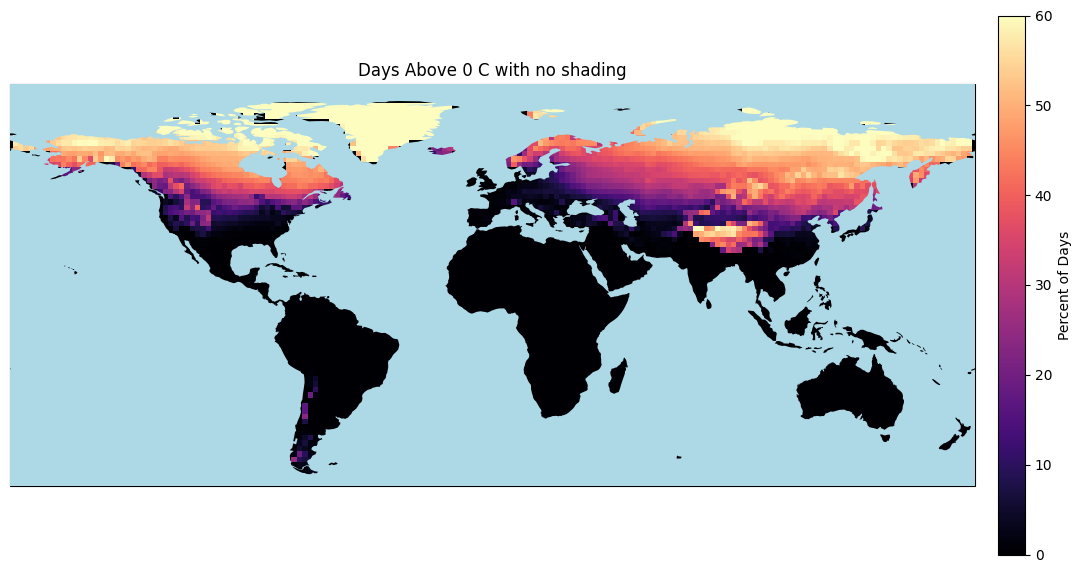

In [480]:
# Plot the heatmap
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
plot_single_heatmap(ax, vmin = 0, vmax = 60, data = cold_time_45_no_shading, days = True, sensitivity = "no shading", threshold = 0)


## Analyzing Solar Data

In [264]:
import os

# Specify the directory
directory = "solar"

# List all files in the directory and its subdirectories
coords = []
for root, dirs, files in os.walk(directory):
    for file in files:
        coord = file.split(".")[0]
        if coord not in coords:
            coords.append(coord)


In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def fraction_days_solar(coords):
    # Initialize a dictionary to store results
    fractions = []

    # Process each coordinate
    for coord in coords:  # Limit to the first 10 coordinates
        lat = int(coord.split('_')[0])
        lon = int(coord.split('_')[1])

        # Load the DataFrame
        try:
            df = pd.read_pickle(f'solar/{coord}.pkl')

            # Ensure datetime index is in place
            if not isinstance(df.index, pd.DatetimeIndex):
                df.set_index('datetime', inplace=True)

            # Resample data to daily frequency and check for threshold
            days_with_threshold = df['charges'].resample('D').min() <= 1000

            # Calculate fraction of days exceeding the threshold
            fraction_above_threshold = days_with_threshold.sum() / len(days_with_threshold)
            fractions.append({'lat': lat, 'lon': lon, 'fraction': fraction_above_threshold})

        except Exception as e:
            print(f"Error processing {coord}: {e}")

    # Convert results to a DataFrame
    fraction_df = pd.DataFrame(fractions)

    # Create pivot table for heatmap
    heatmap_data = fraction_df.pivot(index='lat', columns='lon', values='fraction')
    
    # Apply the filter: 3x3 window to average valid neighbors
    # Apply only on NaN positions (using 'constant' mode for filling boundary)
    filled_values = generic_filter(heatmap_data.values, average_neighbors, size=5, mode='constant', cval=np.nan)

    # Convert the result into a DataFrame while keeping the original index and columns
    new = pd.DataFrame(filled_values, index=heatmap_data.index, columns=heatmap_data.columns)

    # Now, only update NaN values in the original dataframe with the filled ones
    result = heatmap_data.copy()  # Make a copy to preserve the original
    result[heatmap_data.isna()] = new[heatmap_data.isna()]

    return result

def fraction_points_solar(coords):
    # Initialize a dictionary to store results
    fractions = []

    # Process each coordinate
    for coord in coords:  # Limit to the first 10 coordinates
        lat = int(coord.split('_')[0])
        lon = int(coord.split('_')[1])

        # Load the DataFrame
        try:
            df = pd.read_pickle(f'solar/{coord}.pkl')

            # Ensure datetime index is in place
            if not isinstance(df.index, pd.DatetimeIndex):
                df.set_index('datetime', inplace=True)

            # Resample data to daily frequency and check for threshold
            days_with_threshold  = df['charges'] <= 1000

            # Calculate fraction of days exceeding the threshold
            fraction_above_threshold = days_with_threshold.sum() / len(days_with_threshold)
            fractions.append({'lat': lat, 'lon': lon, 'fraction': fraction_above_threshold})

        except Exception as e:
            print(f"Error processing {coord}: {e}")

    # Convert results to a DataFrame
    fraction_df = pd.DataFrame(fractions)

    # Create pivot table for heatmap
    heatmap_data = fraction_df.pivot(index='lat', columns='lon', values='fraction')
    
    # Apply the filter: 3x3 window to average valid neighbors
    # Apply only on NaN positions (using 'constant' mode for filling boundary)
    filled_values = generic_filter(heatmap_data.values, average_neighbors, size=5, mode='constant', cval=np.nan)

    # Convert the result into a DataFrame while keeping the original index and columns
    new = pd.DataFrame(filled_values, index=heatmap_data.index, columns=heatmap_data.columns)

    # Now, only update NaN values in the original dataframe with the filled ones
    result = heatmap_data.copy()  # Make a copy to preserve the original
    result[heatmap_data.isna()] = new[heatmap_data.isna()]

    return result

heatmap_data = fraction_days_solar(coords)
heatmap_points = fraction_points_solar(coords)

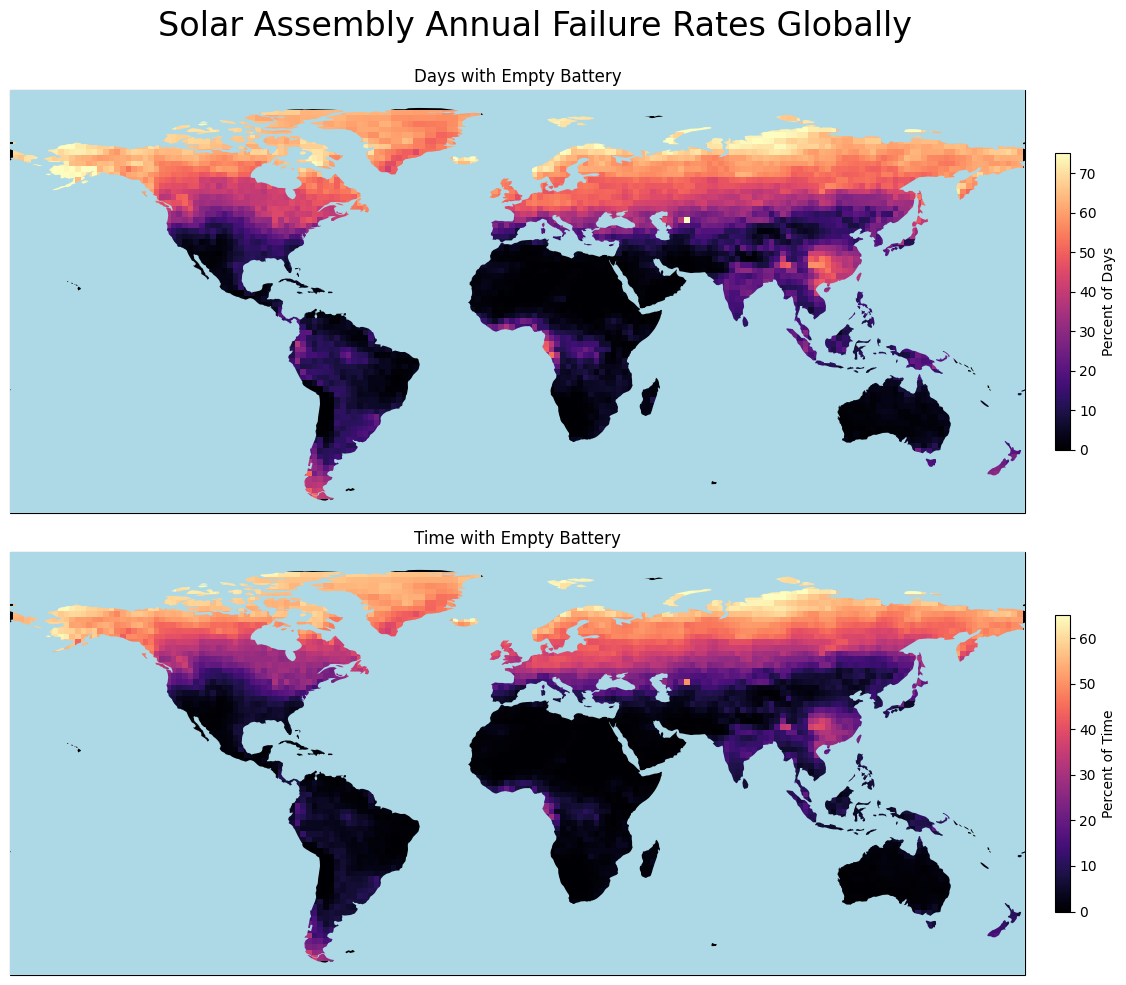

In [463]:
from matplotlib import colors

def plot_single_heatmap_solar(ax, data, vmin, vmax, days = False, extent=[-180, 180, -60, 90]):
    """
    Plots a single heatmap on the provided axis.

    Parameters:
        ax (GeoAxes): A Cartopy GeoAxes object for the subplot.
        data (np.ndarray): 2D array containing the heatmap data.
        extent (list): Map extent in the format [lon_min, lon_max, lat_min, lat_max].
        title (str): Title for the subplot (default is None).

    Returns:
        None
    """
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, facecolor=plt.cm.magma(0))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', alpha=0.5)

    # Plot the heatmap
    lons, lats = np.meshgrid(days_45_no_shading.columns, days_45_no_shading.index)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    im = ax.pcolormesh(
        lons, lats, data *100,
        cmap='magma', norm = norm, shading='auto', transform=ccrs.PlateCarree(), zorder=2
    )
    ax.add_feature(cfeature.OCEAN, zorder = 3, facecolor='lightblue')


    # Add colorbar
    cbar = plt.colorbar(im, orientation='vertical', ax=ax, shrink=0.7, pad=0.02)
    
    if days:
        cbar.set_label('Percent of Days')
        ax.set_title(f"Days with Empty Battery")

    else:
        cbar.set_label('Percent of Time')
        ax.set_title(f"Time with Empty Battery")


    # Add gridlines and labels
    #ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

nrows, ncols = 2, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Solar Assembly Annual Failure Rates Globally ", fontsize=24, x=0.5)

plot_single_heatmap_solar(axes[0], vmin = 0, vmax = 75, data = heatmap_data, days = True)
plot_single_heatmap_solar(axes[1], vmin = 0, vmax = 65, data = heatmap_points, days = False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(top=0.9)  # Reduce the top margin

plt.show()

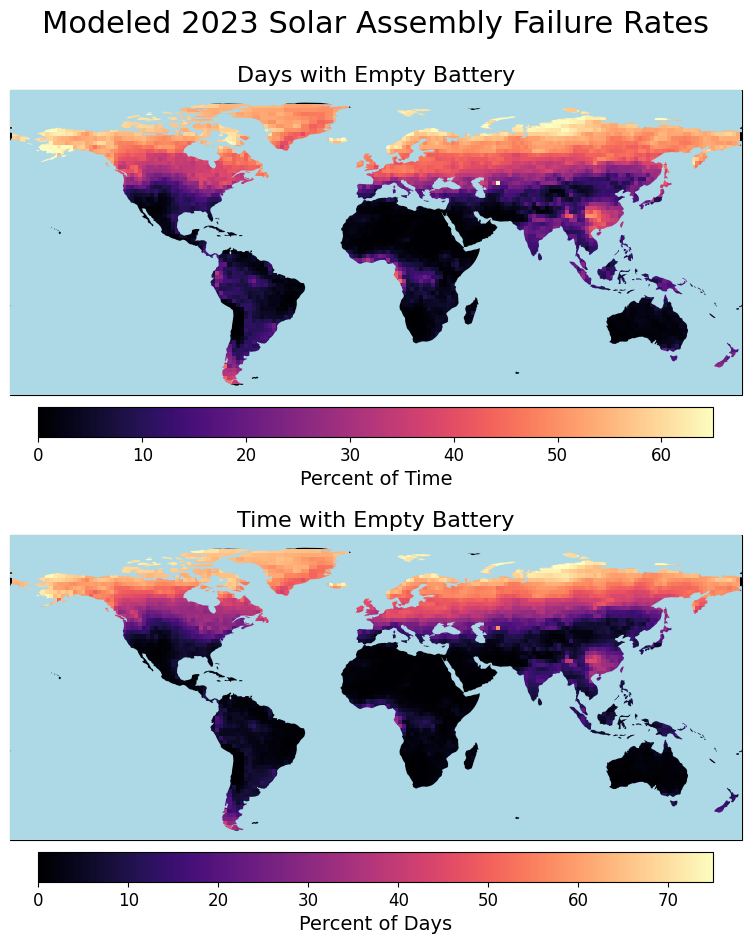

In [559]:
from matplotlib import colors

def plot_single_heatmap_solar(ax, data, vmin, vmax, days=False, extent=[-180, 180, -60, 90]):
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add geographical features
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='lightblue')
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, facecolor=plt.cm.magma(0))
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue', alpha=0.5)

    # Plot the heatmap
    lons, lats = np.meshgrid(days_45_no_shading.columns, days_45_no_shading.index)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    im = ax.pcolormesh(
        lons, lats, data * 100,
        cmap='magma', norm=norm, shading='auto', transform=ccrs.PlateCarree(), zorder=2
    )
    ax.add_feature(cfeature.OCEAN, zorder=3, facecolor='lightblue')

    return im  # Return color mesh object for colorbar reference

# Create figure and subplots
nrows, ncols = 2, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("Modeled 2023 Solar Assembly Failure Rates", fontsize=22, x=0.5)

# Generate plots
im1 = plot_single_heatmap_solar(axes[0], vmin=0, vmax=75, data=heatmap_data, days=True)
im2 = plot_single_heatmap_solar(axes[1], vmin=0, vmax=65, data=heatmap_points, days=False)

axes[0].set_title("Days with Empty Battery", fontsize=16)
axes[1].set_title("Time with Empty Battery", fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.93])
fig.subplots_adjust(top=0.9, bottom = 0.15, hspace=0.46)  # Adjust space between plots

# Create shared horizontal colorbars
cbar_ax_top = fig.add_axes([0.275, 0.108, 0.45, 0.03])  # [x, y, width, height]
cbar_top = plt.colorbar(im1, cax=cbar_ax_top, orientation='horizontal')
cbar_top.set_label('Percent of Days', fontsize=14)
cbar_top.ax.tick_params(labelsize=12)

cbar_ax_bottom = fig.add_axes([0.275, 0.553, 0.45, 0.03])
cbar_bottom = plt.colorbar(im2, cax=cbar_ax_bottom, orientation='horizontal')
cbar_bottom.set_label('Percent of Time', fontsize=14)
cbar_bottom.ax.tick_params(labelsize=12)

plt.show()


In [ ]:
## Analyzing Solar Data

## India Case Study Model

In [348]:

# Initialize the logger
logging.basicConfig(
    filename='delhi.log',  # Name of the log file
    level=logging.INFO,                   # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S'           # Time format
)

# Create logger instance
logger = logging.getLogger()

In [360]:
# get  model results for 28.6139° N, 77.2088° E
lat = 28.6139
lon = 77.2088
results = multiple_temperature_simulations(latitude=lat, longitude=lon, logging = logger,
                             T_max=45 + 273.15, T_initial=20 + 273.15, 
                             B_air=0.00367, v_air=15.89e-6, k_air=0.024, alpha_air=22.5e-6, h_max=200, N=4, 
							 box_parameters = [
							{
								'simulation_name': "solar_shield",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': True,
								'shading_ranges': [],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 }
							 ],
                             start_date_time='2014-01-01 00:00:00', 
                             end_date_time='2023-12-31 23:59:00',
                             stop_event = None,
							)

In [361]:
results_solar  = multiple_solar_simulations(latitude=lat, longitude=lon, logging = logger,
							solar_parameters = [{
								'simulation_name':'base',
								'solar_panel_area': 0.5, 
								'solar_panel_tilt': 0,
								'solar_panel_azimuth': 0,
								'solar_panel_efficiency': 0.18,
								'battery_rated_capacity': 300,
								'battery_efficiency': 0.8,
								'power_consumption': 5,
								'shading_ranges': [],
							}],
							start_solar_time='2014-01-01 00:00:00', 
							end_solar_time='2023-12-31 23:59:59',
							dt_solar = 10,
							stop_event = None,
							)

*** Modelling Solar (28.6139, 77.2088) ***


In [362]:
solar_data = results_solar['base']['data']
solar_data.to_csv('india_10_year_solar.csv')

In [363]:
temp_data = results['solar_shield']['data']
temp_data.to_csv('india_10_year_temp.csv')

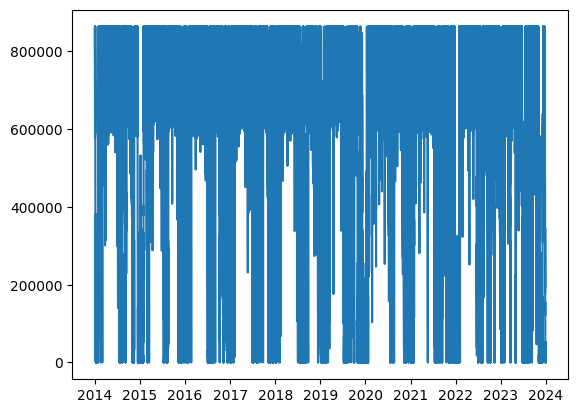

In [364]:
plt.plot(solar_data.index, solar_data['charges'])

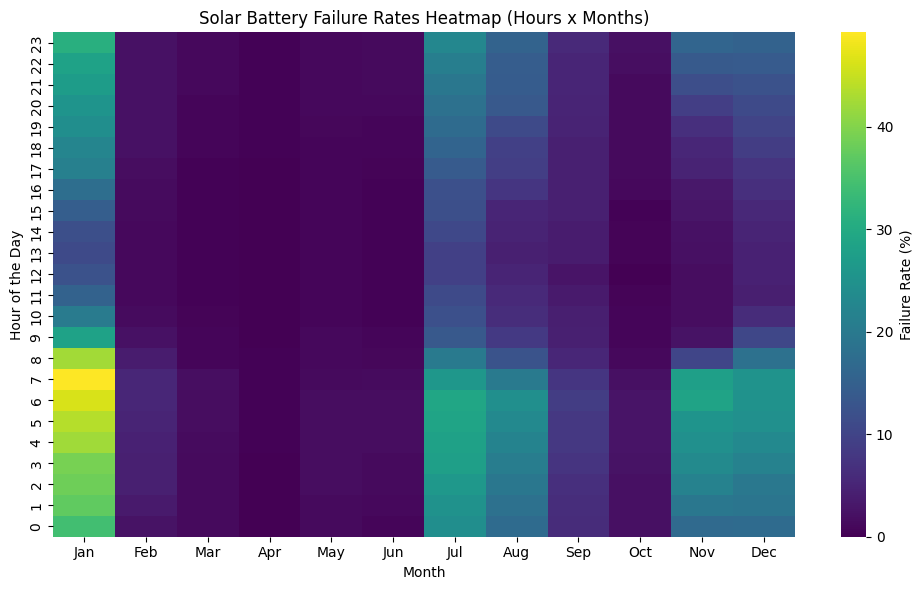

In [375]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def chart_solar_failure_matplotlib(solar_data):
    """
    Create a heatmap of solar battery failure for each hour of each month of the year (10 years of historical data 2014-2023 used)

    Parameters:
    solar_data - the solar model predictions of battery power and charge over time for 10 years

    Returns:
    fig - Matplotlib figure of monthly hourly solar energy failure
    """

    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='viridis', ax=ax, cbar_kws={'label': 'Failure Rate (%)'})

    # Customize the plot
    ax.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')

    # Set the x-axis to show month abbreviations
    ax.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
    ax.set_xticklabels(month_abbr)

    plt.tight_layout()

    return fig

fig = chart_solar_failure_matplotlib(solar_data)

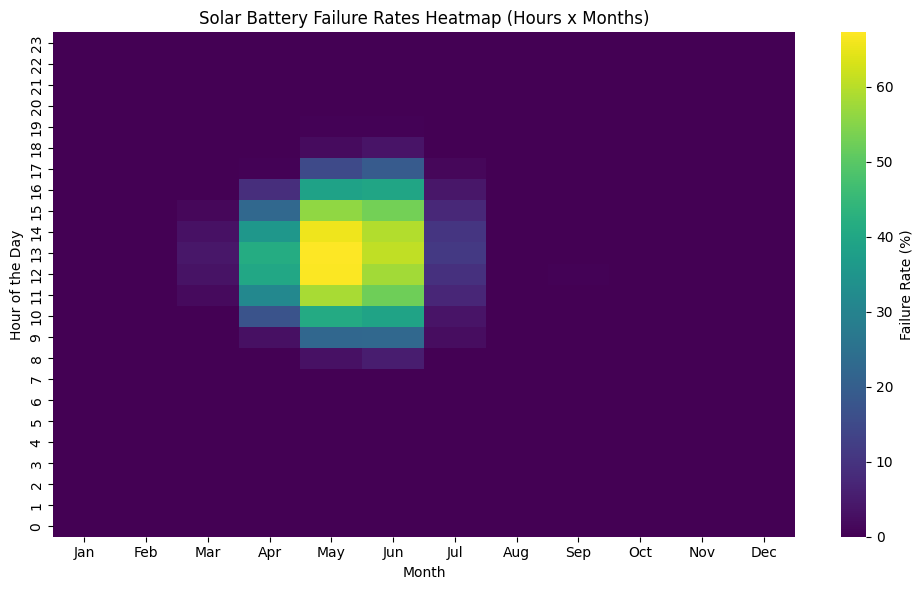

In [376]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def chart_temp_failure_matplotlib(solar_data):
    """
    Create a heatmap of solar battery failure for each hour of each month of the year (10 years of historical data 2014-2023 used)

    Parameters:
    solar_data - the solar model predictions of battery power and charge over time for 10 years

    Returns:
    fig - Matplotlib figure of monthly hourly solar energy failure
    """

    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['internal'] >= 273.15 + 45) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='viridis', ax=ax, cbar_kws={'label': 'Failure Rate (%)'})

    # Customize the plot
    ax.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')

    # Set the x-axis to show month abbreviations
    ax.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
    ax.set_xticklabels(month_abbr)

    plt.tight_layout()

    return fig

fig = chart_temp_failure_matplotlib(temp_data)

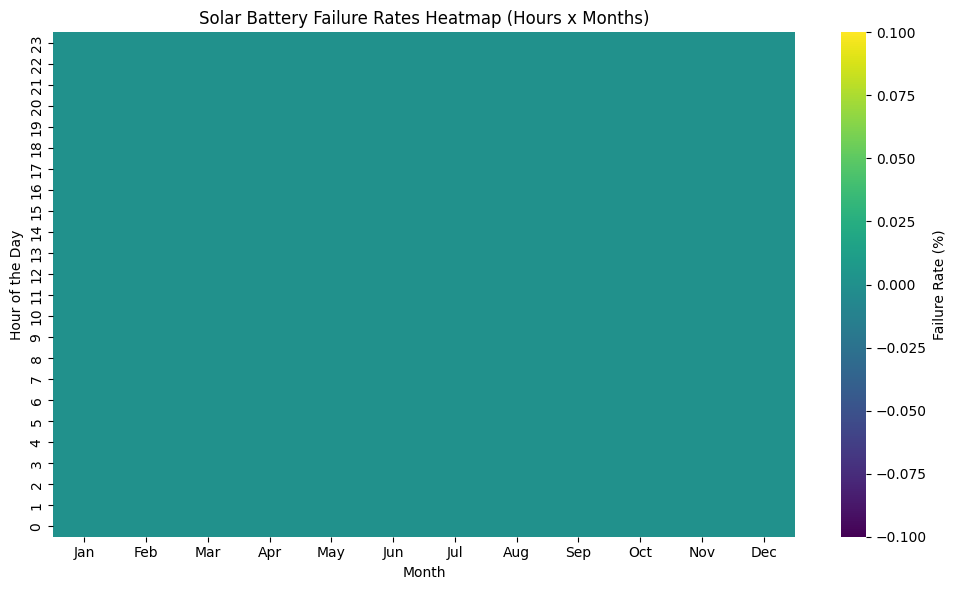

In [478]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def chart_temp_failure_matplotlib(solar_data):
    """
    Create a heatmap of solar battery failure for each hour of each month of the year (10 years of historical data 2014-2023 used)

    Parameters:
    solar_data - the solar model predictions of battery power and charge over time for 10 years

    Returns:
    fig - Matplotlib figure of monthly hourly solar energy failure
    """

    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['internal'] <= 273.15 + 0) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='viridis', ax=ax, cbar_kws={'label': 'Failure Rate (%)'})

    # Customize the plot
    ax.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')

    # Set the x-axis to show month abbreviations
    ax.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
    ax.set_xticklabels(month_abbr)

    plt.tight_layout()

    return fig

fig = chart_temp_failure_matplotlib(temp_data)

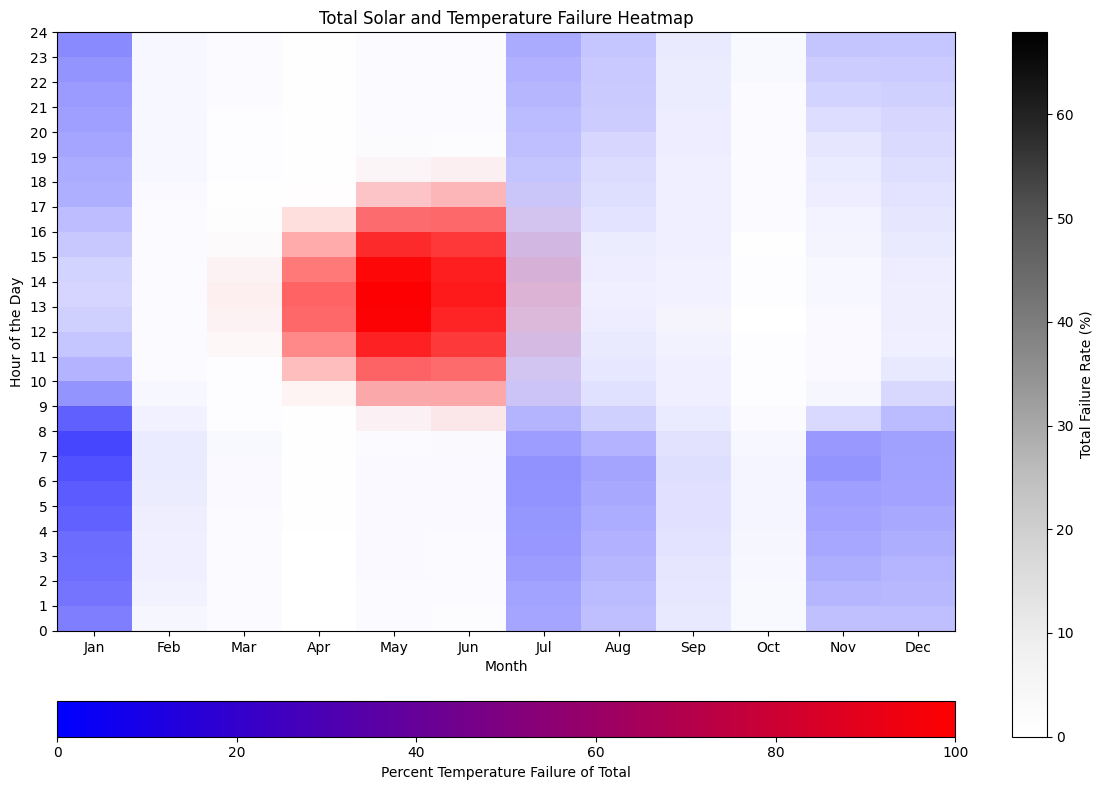

In [472]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


def chart_combined_failure_with_intensity(solar_data, temp_data):
    """
    Create a combined heatmap showing total failure rates and the ratio of solar to temperature failures.

    Parameters:
    solar_data - DataFrame containing solar failure data
    temp_data - DataFrame containing temperature failure data

    Returns:
    fig - Matplotlib figure showing combined failure heatmap
    """
    # Prepare solar failure data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['solar_failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

    # Prepare temperature failure data
    temp_data['month'] = temp_data.index.month
    temp_data['hour'] = temp_data.index.hour
    temp_data['temp_failure'] = (temp_data['internal'] >= 273.15 + 45) * 100

    # Aggregate solar and temperature failures
    solar_agg = solar_data.groupby(['month', 'hour']).agg({'solar_failure': 'mean'}).reset_index()
    temp_agg = temp_data.groupby(['month', 'hour']).agg({'temp_failure': 'mean'}).reset_index()

    # Merge the two datasets
    combined = pd.merge(solar_agg, temp_agg, on=['month', 'hour'])
    combined['total_failure'] = combined['solar_failure'] + combined['temp_failure']
    combined['solar_ratio'] = combined['temp_failure'] / combined['total_failure'] * 100

    # Pivot data for heatmaps
    intensity_matrix = combined.pivot(index='hour', columns='month', values='total_failure')
    ratio_matrix = combined.pivot(index='hour', columns='month', values='solar_ratio')

    # Create a custom colormap for the ratio (hue)
    combined_cmap = LinearSegmentedColormap.from_list('SolarTemp', ['blue', 'purple', 'red'])

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8))
    norm_intensity = Normalize(vmin=0, vmax=intensity_matrix.max().max())
    norm_ratio = Normalize(vmin=0, vmax=100)

    # Map failure rate to alpha and solar-to-temperature ratio to color
    # Map failure rate to alpha and solar-to-temperature ratio to color
    for hour in intensity_matrix.index:
        for month in intensity_matrix.columns:
            intensity = intensity_matrix.loc[hour, month]
            ratio = ratio_matrix.loc[hour, month]
            color = combined_cmap(norm_ratio(ratio))  # Determine color by ratio
            alpha = norm_intensity(intensity)        # Determine transparency by failure rate
            
            # Add rectangle for each cell
            rect = plt.Rectangle(
                (month - 1, hour), 1, 1, 
                facecolor=color, alpha=alpha, edgecolor=None, snap = True
            )
            ax.add_patch(rect)


    # Customize the plot
    ax.set_xlim(0, 12)
    ax.set_yticks(range(25))  # Set ticks for every hour
    ax.set_yticklabels(range(25))  # Label each tick
    ax.invert_yaxis()  # Flip the y-axis so 0 is at the top
    ax.set_title('Total Solar and Temperature Failure Heatmap')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')
    ax.set_xticks(np.arange(0.5, 12, 1))  # Midpoints of the 12 columns
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.invert_yaxis()

    # # Add colorbar for ratio
    # sm_ratio = plt.cm.ScalarMappable(cmap=combined_cmap, norm=norm_ratio)
    # sm_ratio.set_array([])
    # cbar_ratio = fig.colorbar(sm_ratio, ax=ax, orientation='horizontal', pad=0.1)
    # cbar_ratio.set_label('Solar-to-Temperature Failure Ratio')


    divider = make_axes_locatable(ax)
    cax_ratio = divider.append_axes("bottom", size="6%", pad=0.7)  # Position at the bottom
    sm_ratio = plt.cm.ScalarMappable(cmap=combined_cmap, norm=norm_ratio)
    sm_ratio.set_array([])
    cbar_ratio = plt.colorbar(sm_ratio, cax=cax_ratio, orientation='horizontal')
    cbar_ratio.set_label('Percent Temperature Failure of Total')


    # Add colorbar for intensity
    sm_intensity = plt.cm.ScalarMappable(cmap='Greys', norm=norm_intensity)
    sm_intensity.set_array([])
    cbar_intensity = fig.colorbar(sm_intensity, ax=ax, orientation='vertical')
    cbar_intensity.set_label('Total Failure Rate (%)')

    plt.tight_layout()
    return fig, intensity_matrix

# Usage
fig, intensity_matrix= chart_combined_failure_with_intensity(solar_data, temp_data)
plt.show()


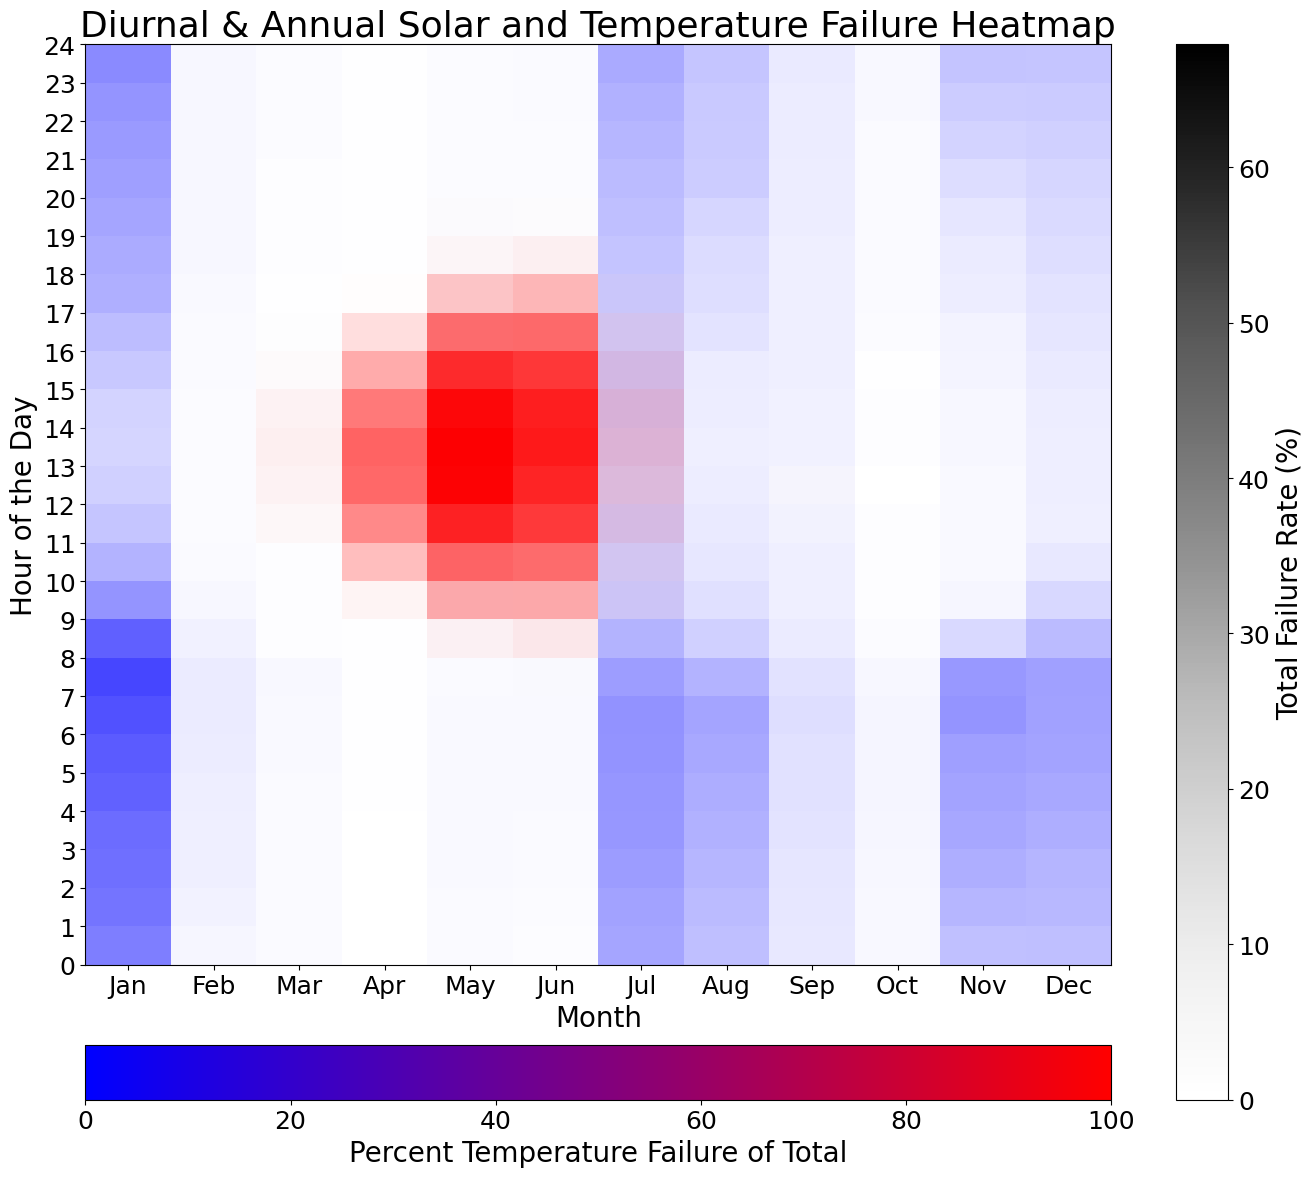

In [660]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Increase global font size
plt.rcParams.update({'font.size': 14})

def chart_combined_failure_with_intensity(solar_data, temp_data):
	"""
	Create a combined heatmap showing total failure rates and the ratio of solar to temperature failures.

	Parameters:
	solar_data - DataFrame containing solar failure data
	temp_data - DataFrame containing temperature failure data

	Returns:
	fig - Matplotlib figure showing combined failure heatmap
	"""
	# Prepare solar failure data
	solar_data['month'] = solar_data.index.month
	solar_data['hour'] = solar_data.index.hour
	solar_data['solar_failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

	# Prepare temperature failure data
	temp_data['month'] = temp_data.index.month
	temp_data['hour'] = temp_data.index.hour
	temp_data['temp_failure'] = (temp_data['internal'] >= 273.15 + 45) * 100

	# Aggregate solar and temperature failures
	solar_agg = solar_data.groupby(['month', 'hour']).agg({'solar_failure': 'mean'}).reset_index()
	temp_agg = temp_data.groupby(['month', 'hour']).agg({'temp_failure': 'mean'}).reset_index()

	# Merge the two datasets
	combined = pd.merge(solar_agg, temp_agg, on=['month', 'hour'])
	combined['total_failure'] = combined['solar_failure'] + combined['temp_failure']
	combined['solar_ratio'] = combined['temp_failure'] / combined['total_failure'] * 100

	# Pivot data for heatmaps
	intensity_matrix = combined.pivot(index='hour', columns='month', values='total_failure')
	ratio_matrix = combined.pivot(index='hour', columns='month', values='solar_ratio')

	# Create a custom colormap for the ratio (hue)
	combined_cmap = LinearSegmentedColormap.from_list('SolarTemp', ['blue', 'purple', 'red'])

	# Create the figure and axes
	fig, ax = plt.subplots(figsize=(14, 12))
	norm_intensity = Normalize(vmin=0, vmax=intensity_matrix.max().max())
	norm_ratio = Normalize(vmin=0, vmax=100)

	# Map failure rate to alpha and solar-to-temperature ratio to color
	for hour in intensity_matrix.index:
		for month in intensity_matrix.columns:
			intensity = intensity_matrix.loc[hour, month]
			ratio = ratio_matrix.loc[hour, month]
			color = combined_cmap(norm_ratio(ratio))  # Determine color by ratio
			alpha = norm_intensity(intensity)        # Determine transparency by failure rate
			
			# Add rectangle for each cell
			rect = plt.Rectangle(
				(month - 1, hour), 1, 1, 
				facecolor=color, alpha=alpha, edgecolor=None, snap=True
			)
			ax.add_patch(rect)

	# Customize the plot
	ax.set_xlim(0, 12)
	ax.set_yticks(range(25))
	ax.set_yticklabels(range(25), fontsize=18)  # Bigger y-tick labels
	ax.invert_yaxis()
	ax.set_title('Diurnal & Annual Solar and Temperature Failure Heatmap', fontsize=26) #fontweight='bold')
	ax.set_xlabel('Month', fontsize=20)
	ax.set_ylabel('Hour of the Day', fontsize=20)
	ax.set_xticks(np.arange(0.5, 12, 1))  
	ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
						'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=18)
	ax.invert_yaxis()

	# Colorbar for ratio
	divider = make_axes_locatable(ax)
	cax_ratio = divider.append_axes("bottom", size="6%", pad=0.8)
	sm_ratio = plt.cm.ScalarMappable(cmap=combined_cmap, norm=norm_ratio)
	sm_ratio.set_array([])
	cbar_ratio = plt.colorbar(sm_ratio, cax=cax_ratio, orientation='horizontal')
	cbar_ratio.set_label('Percent Temperature Failure of Total', fontsize=20)
	cbar_ratio.ax.tick_params(labelsize=18)


	# Colorbar for intensity
	sm_intensity = plt.cm.ScalarMappable(cmap='Greys', norm=norm_intensity)
	sm_intensity.set_array([])
	cbar_intensity = fig.colorbar(sm_intensity, ax=ax, orientation='vertical')
	cbar_intensity.set_label('Total Failure Rate (%)', fontsize=20)
	cbar_intensity.ax.tick_params(labelsize=18)

	plt.tight_layout()
	return fig, intensity_matrix

# Usage
fig, intensity_matrix = chart_combined_failure_with_intensity(solar_data, temp_data)
plt.show()


## Montreal Case Study 

In [ ]:

# Initialize the logger
logging.basicConfig(
    filename='delhi.log',  # Name of the log file
    level=logging.INFO,                   # Set the logging level
    format='%(asctime)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S'           # Time format
)

# Create logger instance
logger = logging.getLogger()

In [ ]:
# 45.5019° N, 73.5674° W
lat = 45.5019
lon = -73.5674
results_montreal = multiple_temperature_simulations(latitude=lat, longitude=lon, logging = logger,
                             T_max=45 + 273.15, T_initial=20 + 273.15, 
                             B_air=0.00367, v_air=15.89e-6, k_air=0.024, alpha_air=22.5e-6, h_max=200, N=4, 
							 box_parameters = [
							{
								'simulation_name': "solar_shield",
								'L':0.2032,
								'W':0.152, 
								'H':0.10922,
								'thicknesses':[0.006, 0.006, 0.006, 0.006, 0.006, 0.006],
								'fan_flow': 0, 
								'heat_generation': 5, 
								'fan_heat_generation': 0, 
								'fan_threshold': 40, 
								'box_shading': True,
								'shading_ranges': [],
								'k': 0.162, 
								'rho': 1070, 
								'Cp': 1990, 
								'emissivity': 0.94, 
								'absorptivity': 0.94, 
							 }
							 ],
                             start_date_time='2014-01-01 00:00:00', 
                             end_date_time='2023-12-31 23:59:00',
                             stop_event = None,
							)

In [ ]:
results_solar_montreal  = multiple_solar_simulations(latitude=lat, longitude=lon, logging = logger,
							solar_parameters = [{
								'simulation_name':'base',
								'solar_panel_area': 0.5, 
								'solar_panel_tilt': 0,
								'solar_panel_azimuth': 0,
								'solar_panel_efficiency': 0.18,
								'battery_rated_capacity': 300,
								'battery_efficiency': 0.8,
								'power_consumption': 5,
								'shading_ranges': [],
							}],
							start_solar_time='2014-01-01 00:00:00', 
							end_solar_time='2023-12-31 23:59:59',
							dt_solar = 10,
							stop_event = None,
							)

In [ ]:
solar_data_montreal = results_solar_montreal['base']['data']
solar_data_montreal.to_csv('montreal_10_year_solar.csv')

In [ ]:
temp_data_montreal = results_montreal['solar_shield']['data']
temp_data_montreal.to_csv('montreal_10_year_temp.csv')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def chart_solar_failure_matplotlib(solar_data):
    """
    Create a heatmap of solar battery failure for each hour of each month of the year (10 years of historical data 2014-2023 used)

    Parameters:
    solar_data - the solar model predictions of battery power and charge over time for 10 years

    Returns:
    fig - Matplotlib figure of monthly hourly solar energy failure
    """

    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='viridis', ax=ax, cbar_kws={'label': 'Failure Rate (%)'})

    # Customize the plot
    ax.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')

    # Set the x-axis to show month abbreviations
    ax.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
    ax.set_xticklabels(month_abbr)

    plt.tight_layout()

    return fig

fig = chart_solar_failure_matplotlib(solar_data)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def chart_temp_failure_matplotlib(solar_data):
    """
    Create a heatmap of solar battery failure for each hour of each month of the year (10 years of historical data 2014-2023 used)

    Parameters:
    solar_data - the solar model predictions of battery power and charge over time for 10 years

    Returns:
    fig - Matplotlib figure of monthly hourly solar energy failure
    """

    # Prepare data
    solar_data['month'] = solar_data.index.month
    solar_data['hour'] = solar_data.index.hour
    solar_data['failure'] = (solar_data['internal'] >= 273.15 + 45) * 100

    # Aggregate the data
    agg_df = solar_data.groupby(['month', 'hour']).agg({'failure': 'mean'}).reset_index()

    # Pivot the data to create a matrix for the heatmap
    heatmap_data = agg_df.pivot(index='hour', columns='month', values='failure').sort_index(ascending=False)

    # Define month abbreviations
    month_abbr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='viridis', ax=ax, cbar_kws={'label': 'Failure Rate (%)'})

    # Customize the plot
    ax.set_title('Solar Battery Failure Rates Heatmap (Hours x Months)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Hour of the Day')

    # Set the x-axis to show month abbreviations
    ax.set_xticks(np.arange(0.5, len(month_abbr) + 0.5))
    ax.set_xticklabels(month_abbr)

    plt.tight_layout()

    return fig

fig = chart_temp_failure_matplotlib(temp_data)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Increase global font size
plt.rcParams.update({'font.size': 14})

def chart_combined_failure_with_intensity(solar_data, temp_data):
	"""
	Create a combined heatmap showing total failure rates and the ratio of solar to temperature failures.

	Parameters:
	solar_data - DataFrame containing solar failure data
	temp_data - DataFrame containing temperature failure data

	Returns:
	fig - Matplotlib figure showing combined failure heatmap
	"""
	# Prepare solar failure data
	solar_data['month'] = solar_data.index.month
	solar_data['hour'] = solar_data.index.hour
	solar_data['solar_failure'] = (solar_data['charges'] / 3600 <= 0.001) * 100

	# Prepare temperature failure data
	temp_data['month'] = temp_data.index.month
	temp_data['hour'] = temp_data.index.hour
	temp_data['temp_failure'] = (temp_data['internal'] >= 273.15 + 45) * 100

	# Aggregate solar and temperature failures
	solar_agg = solar_data.groupby(['month', 'hour']).agg({'solar_failure': 'mean'}).reset_index()
	temp_agg = temp_data.groupby(['month', 'hour']).agg({'temp_failure': 'mean'}).reset_index()

	# Merge the two datasets
	combined = pd.merge(solar_agg, temp_agg, on=['month', 'hour'])
	combined['total_failure'] = combined['solar_failure'] + combined['temp_failure']
	combined['solar_ratio'] = combined['temp_failure'] / combined['total_failure'] * 100

	# Pivot data for heatmaps
	intensity_matrix = combined.pivot(index='hour', columns='month', values='total_failure')
	ratio_matrix = combined.pivot(index='hour', columns='month', values='solar_ratio')

	# Create a custom colormap for the ratio (hue)
	combined_cmap = LinearSegmentedColormap.from_list('SolarTemp', ['blue', 'purple', 'red'])

	# Create the figure and axes
	fig, ax = plt.subplots(figsize=(14, 12))
	norm_intensity = Normalize(vmin=0, vmax=intensity_matrix.max().max())
	norm_ratio = Normalize(vmin=0, vmax=100)

	# Map failure rate to alpha and solar-to-temperature ratio to color
	for hour in intensity_matrix.index:
		for month in intensity_matrix.columns:
			intensity = intensity_matrix.loc[hour, month]
			ratio = ratio_matrix.loc[hour, month]
			color = combined_cmap(norm_ratio(ratio))  # Determine color by ratio
			alpha = norm_intensity(intensity)        # Determine transparency by failure rate
			
			# Add rectangle for each cell
			rect = plt.Rectangle(
				(month - 1, hour), 1, 1, 
				facecolor=color, alpha=alpha, edgecolor=None, snap=True
			)
			ax.add_patch(rect)

	# Customize the plot
	ax.set_xlim(0, 12)
	ax.set_yticks(range(25))
	ax.set_yticklabels(range(25), fontsize=18)  # Bigger y-tick labels
	ax.invert_yaxis()
	ax.set_title('Diurnal & Annual Solar and Temperature Failure Heatmap', fontsize=26) #fontweight='bold')
	ax.set_xlabel('Month', fontsize=20)
	ax.set_ylabel('Hour of the Day', fontsize=20)
	ax.set_xticks(np.arange(0.5, 12, 1))  
	ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
						'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=18)
	ax.invert_yaxis()

	# Colorbar for ratio
	divider = make_axes_locatable(ax)
	cax_ratio = divider.append_axes("bottom", size="6%", pad=0.8)
	sm_ratio = plt.cm.ScalarMappable(cmap=combined_cmap, norm=norm_ratio)
	sm_ratio.set_array([])
	cbar_ratio = plt.colorbar(sm_ratio, cax=cax_ratio, orientation='horizontal')
	cbar_ratio.set_label('Percent Temperature Failure of Total', fontsize=20)
	cbar_ratio.ax.tick_params(labelsize=18)


	# Colorbar for intensity
	sm_intensity = plt.cm.ScalarMappable(cmap='Greys', norm=norm_intensity)
	sm_intensity.set_array([])
	cbar_intensity = fig.colorbar(sm_intensity, ax=ax, orientation='vertical')
	cbar_intensity.set_label('Total Failure Rate (%)', fontsize=20)
	cbar_intensity.ax.tick_params(labelsize=18)

	plt.tight_layout()
	return fig, intensity_matrix

# Usage
fig, intensity_matrix = chart_combined_failure_with_intensity(solar_data, temp_data)
plt.show()
